# Working with the MagIC database using PmagPy

The Magnetics Information Consortium (MagIC) maintains a database of published rock and paleomagnetic data: https://www.earthref.org/MagIC 

Many **PmagPy** scripts are designed to work with data in the MagIC format.  This notebook uses Data Model 3.0: https://www.earthref.org/MagIC/data-models/3.0   

There are nine basic tables: contribution, locations, sites, samples, specimens, measurements, criteria, ages and images.   These are tab delimited data tables with the first line consisting of a delimiter and the table name: (e.g.,  tab    measurements).  All of the examples here are tab delimited.  The second line contains the column names: (e.g., specimen experiment method_codes treat_temp.....).  Each subsequent line is a single record.

See the first few lines of this sample file below:

In [1]:
with open('data_files/3_0/McMurdo/samples.txt') as f:
    for line in f.readlines()[:3]:
        print(line, end="")

tab 	samples
azimuth	azimuth_dec_correction	citations	description	dip	geologic_classes	geologic_types	lat	lithologies	lon	method_codes	orientation_quality	sample	site
260	0	This study	Archived samples from 1965, 66 expeditions.	-57	Extrusive:Igneous	Lava Flow	-77.85	Trachyte	166.64	SO-SIGHT:FS-FD	g	mc01a	mc01


## Guide to PmagPy

The notebook is one of a series of notebooks that demonstrate the functionality of PmagPy. The other notebooks are:

- [PmagPy_introduction.ipynb](PmagPy_introduction.ipynb) This notebook introduces PmagPy and lists the functions that are demonstrated in the other notebooks. 
- [PmagPy_calculations.ipynb](PmagPy_calculations.ipynb) This notebook demonstrates many of the PmagPy calculation functions such as those that rotate directions, return statistical parameters, and simulate data from specified distributions. 
- [PmagPy_plots_analysis.ipynb](PmagPy_plots_analysis.ipynb) This notebook demonstrates PmagPy functions that can be used to visualize data as well as those that conduct statistical tests that have associated visualizations.

## Customizing this notebook

If you want to make changes to this notebook, you should make a copy (see File menu).  Otherwise each time you update **PmagPy**, your changes will be overwritten.

## Get started

To use the functions in this notebook, we have to   import the **PmagPy** modules **pmagplotlib**, **pmag** and **ipmag** and some other handy functions for use in the notebook.  This is done in the following code block which must be executed before running any other code block. To execute, click on the code block and then click on the "Run" button in the menu.  

In order to access the example data, this notebook is meant to be run in the PmagPy-data directory (PmagPy directory for developers).

Try it!  Run the code block below (click on the cell and then click 'Run'):

In [2]:
import pmagpy.pmag as pmag
import pmagpy.pmagplotlib as pmagplotlib
import pmagpy.ipmag as ipmag
import pmagpy.contribution_builder as cb
from pmagpy import convert_2_magic as convert
import matplotlib.pyplot as plt # our plotting buddy
import numpy as np # the fabulous NumPy package
import pandas as pd # and of course Pandas
# test if Basemap and/or cartopy is installed
has_basemap, Basemap = pmag.import_basemap()
has_cartopy, Cartopy = pmag.import_cartopy()
# test if xlwt is installed (allows you to export to excel)
try:
    import xlwt
    has_xlwt = True
except ImportError:
    has_xlwt = False
# This allows you to make matplotlib plots inside the notebook.  
%matplotlib inline 
from IPython.display import Image
import os

print('All modules imported!')

All modules imported!


# Table of contents
- Functions in **PmagPy_MagIC.ipynb**
    - [reading MagIC files](#magic_read) : reading in MagIC formatted files
    - [writing MagIC files](#magic_write) : outputing MagIC formatted files
    - [combine_magic](#combine_magic) : combines two MagIC formatted files of same type
    - [convert_ages](#convert_ages) : convert ages in downloaded MagIC file to Ma
    - [grab_magic_key](#grab_magic_key) : prints out a single column from a MagIC format file
    - [magic_select](#magic_select) : selects data from MagIC format file given conditions (e.g., method_codes contain string)
    - [sites_extract](#sites_extract) : makes excel or latex files from sites.txt for publications
    - [criteria_extract](#criteria_extract) : makes excel or latex files from criteria.txt for publications
    - [specimens_extract](#specimens_extract) : makes excel or latex files from specimens.txt for publications
    - [contributions](#Contributions) work with data model 3.0 MagIC contributions
        - [download_magic](#download_magic) : unpacks a contribution text file downloaded from the MagIC website
        - [upload_magic](#upload_magic) : prepares a directory with a MagIC contribution for uploading to MagIC
        - [cb.add_sites_to_meas_table](#cb.add_sites_to_meas_table) : completes a measurements data frame with the information required for plotting by site. 
        - [cb.get_intensity_col](#cb.get_intensity_col) : finds the first non-zero type of intensity data in a measurements dataframe.
    - [conversion scripts](#Conversion-Scripts) : convert many laboratory measurement formats to the MagIC data model 3 format
        - [\_2g\_asc_magic](#\_2g\_asc\_magic) : converts 2G ascii files to MagIC
        - [\_2g\_bin_magic](#\_2g\_bin\_magic) : converts 2G binary files to MagIC
        - [agm_magic](#agm_magic) : converts Princeton Measurements alternating gradient force magnetization (AGM) files to MagIC.
        - [bgc_magic](#bgc_magic) : convert Berkeley Geochronology Center files to MagIC. 
        - [cit_magic](#cit_magic) : convert Cal Tech format files to MagIC.
        - [generic_magic](#generic_magic) : converts generic files to MagIC. 
        - [huji_magic](#huji_magic) : converts Hebrew University, Jerusalem, Israel files to MagIC.
        - [huji_sample_magic](#huji_sample_magic) : converts HUJI files to a MagIC format. 
        - [iodp_dscr_lore](#iodp_dscr_lore) : converts IODP discrete measurement files to MagIC
        - [iodp_jr6_lore](#iodp_jr6_lore) : converts IODP JR6 measurement files to MagIC
        - [iodp_samples_csv](#iodp_dscr_lore) : converts IODP samples file to MagIC
        - [iodp_srm_lore](#iodp_srm_lore) : converts IODP archive half measurement files to MagIC   
        - [jr6_jr6_magic](#jr6_jr6_magic) : converts the AGICO JR6 spinner .jr6 files to MagIC 
        - [jr6_txt_magic](#jr6_txt_magic) : converts the AGICO JR6 .txt files to MagIC
        - [k15_magic](#k15_magic) : converts 15 measurement anisotropy of magnetic susceptibility files to MagIC.
        - [kly4s_magic](#kly4s_magic) : converts SIO KLY4S formatted files to MagIC.
        - [ldeo_magic](#ldeo_magic) : converts Lamont-Doherty files to MagIC.  
        - [livdb_magic](#livdb_magic) : converts Liverpool files to MagIC.  
        - [mst_magic](#mst_magic) : converts Curie Temperature experimental data to MagIC
        - [sio_magic](#sio_magic) : converts Scripps Institution of Oceanography data files to MagIC 
        - [sufar4_magic](#sufar4_magic) : converts AGICO SUFAR program (ver.1.2.) ascii files to MagIC
        - [tdt_magic](#tdt_magic) : converts Thellier Tool files to MagIC
        - [utrecht_magic](#utrecht_magic) : converts Fort Hoofddijk, Utrecht University Robot files to MagIC
        - [orientation_magic](#orientation_magic) : converts an "orient.txt" formatted file with field notebook information into MagIC formatted files
        - [azdip_magic](#azdip_magic) : converts an "azdip" formatted file to a samples.txt file format
- other handy scripts
    - [chartmaker](#chartmaker) : script for making chart to guide IZZI lab experiment

### I/O with MagIC data files

### magic_read

- MagIC formatted data files can be imported to a notebook in one of two ways: a

    - importing to a Pandas DataFrame using the Pandas pd.read_csv() function
    - importing to a list of dictionaries using the pmag.magic_read() function.  
    
    In this notebook, we generally read MagIC tables into a Pandas Dataframe with a command like: 

`meas_df = pd.read_csv('MEASUREMENTS_FILE_PATH',sep='\t',header=1)`

These data can then be manipulated with **Pandas** functions (https://pandas.pydata.org/)


In [3]:
meas_df=pd.read_csv('data_files/3_0/McMurdo/measurements.txt',sep='\t',header=1)
meas_df.head()

,experiment,specimen,measurement,dir_csd,dir_dec,dir_inc,hyst_charging_mode,hyst_loop,hyst_sweep_rate,treat_ac_field,...,timestamp,magn_r2_det,magn_x_sigma,magn_xyz_sigma,magn_y_sigma,magn_z_sigma,susc_chi_mass,susc_chi_qdr_mass,susc_chi_qdr_volume,susc_chi_volume
0,mc01f-LP-DIR-AF,mc01f,mc01f-LP-DIR-AF1,0.4,171.9,31.8,NaN,NaN,NaN,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mc01f-LP-DIR-AF,mc01f,mc01f-LP-DIR-AF2,0.4,172.0,30.1,NaN,NaN,NaN,0.0050,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,mc01f-LP-DIR-AF,mc01f,mc01f-LP-DIR-AF3,0.5,172.3,30.4,NaN,NaN,NaN,0.0075,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,mc01f-LP-DIR-AF,mc01f,mc01f-LP-DIR-AF4,0.4,172.1,30.4,NaN,NaN,NaN,0.0100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mc01f-LP-DIR-AF,mc01f,mc01f-LP-DIR-AF5,0.5,171.9,30.8,NaN,NaN,NaN,0.0125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Alternatively, the user may wish to use a list of dictionaries compatible with many **pmag** functions.  For that, use the **pmag.magic_read()** function: 

In [4]:
help (pmag.magic_read)

Help on function magic_read in module pmagpy.pmag:

magic_read(infile, data=None, return_keys=False, verbose=False)
    Reads  a Magic template file, returns  data in a list of dictionaries.
    
    Parameters
    ___________
        Required:
            infile : the MagIC formatted tab delimited data file
                first line contains 'tab' in the first column and the data file type in the second (e.g., measurements, specimen, sample, etc.)
        Optional:
            data : data read in with, e.g., file.readlines()
    Returns
    _______
        list of dictionaries, file type



In [5]:
meas_dict,file_type=pmag.magic_read('data_files/3_0/McMurdo/measurements.txt')
print (file_type)
print (meas_dict[0])

measurements
{'experiment': 'mc01f-LP-DIR-AF', 'specimen': 'mc01f', 'measurement': 'mc01f-LP-DIR-AF1', 'dir_csd': '0.4', 'dir_dec': '171.9', 'dir_inc': '31.8', 'hyst_charging_mode': '', 'hyst_loop': '', 'hyst_sweep_rate': '', 'treat_ac_field': '0.0', 'treat_ac_field_dc_off': '', 'treat_ac_field_dc_on': '', 'treat_ac_field_decay_rate': '', 'treat_dc_field': '0.0', 'treat_dc_field_ac_off': '', 'treat_dc_field_ac_on': '', 'treat_dc_field_decay_rate': '', 'treat_dc_field_phi': '0.0', 'treat_dc_field_theta': '0.0', 'treat_mw_energy': '', 'treat_mw_integral': '', 'treat_mw_power': '', 'treat_mw_time': '', 'treat_step_num': '1', 'treat_temp': '273', 'treat_temp_dc_off': '', 'treat_temp_dc_on': '', 'treat_temp_decay_rate': '', 'magn_mass': '', 'magn_moment': '2.7699999999999996e-05', 'magn_volume': '', 'citations': 'This study', 'instrument_codes': '', 'method_codes': 'LT-NO:LP-DIR-AF', 'quality': 'g', 'standard': 'u', 'meas_field_ac': '', 'meas_field_dc': '', 'meas_freq': '', 'meas_n_orient':

### magic_write

To write out a  MagIC table from a Pandas DataFrame, first convert it to a list of dictionaries using a command like:

`dicts = df.to_dict('records')`



then call **pmag.magic_write()**.

From a list of dictionaries, you can just call **pmag.magic_write()** directly.  



### pmag.magic_write

In [6]:
help(pmag.magic_write)

Help on function magic_write in module pmagpy.pmag:

magic_write(ofile, Recs, file_type)
    Parameters
    _________
    ofile : path to output file
    Recs : list of dictionaries in MagIC format
    file_type : MagIC table type (e.g., specimens)
    
    Return :
    [True,False] : True if successful
    ofile : same as input
    
    Effects :
        writes a MagIC formatted file from Recs



In [7]:
meas_dicts = meas_df.to_dict('records')
pmag.magic_write('my_measurements.txt', meas_dicts, 'measurements')

25470  records written to file  my_measurements.txt


(True, 'my_measurements.txt')

### combine_magic

[\[MagIC Database\]](https://earthref.org/MagIC)  [\[command line version\]](https://pmagpy.github.io/PmagPy-cli.html#combine_magic.py)
 
 MagIC tables have many columns only some of which are used in a particular instance. So combining files of the same type must be done carefully to ensure that the right data come under the right headings. The program **combine_magic** can be used to combine any number of MagIC files from a given type.  
It  reads in MagIC formatted files of a common type (e.g., sites.txt) and combines them into a single file, taking care that all the columns are preserved. For example, if there are both AF and thermal data from a study and we created a measurements.txt formatted file for each, we could use **combine_magic.py** on the command line to combine them together into a single measurements.txt file.   In a notebook, we use  **ipmag.combine_magic()**.  


In [8]:
help(ipmag.combine_magic)

Help on function combine_magic in module pmagpy.ipmag:

combine_magic(filenames, outfile='measurements.txt', data_model=3, magic_table='measurements', dir_path='.', input_dir_path='')
    Takes a list of magic-formatted files, concatenates them, and creates a
    single file. Returns output filename if the operation was successful.
    
    Parameters
    -----------
    filenames : list of MagIC formatted files
    outfile : name of output file [e.g., measurements.txt]
    data_model : data model number (2.5 or 3), default 3
    magic_table : name of magic table, default 'measurements'
    dir_path : str
        output directory, default "."
    input_dir_path : str
        input file directory (if different from dir_path), default ""
    
    
    Returns
    ----------
    outfile name if success, False if failure



Here we make a list of names of two MagIC formatted measurements.txt files and use **ipmag.combine_magic()** to put them together.

In [9]:
filenames=['data_files/combine_magic/af_measurements.txt','../combine_magic/therm_measurements.txt']
outfile='data_files/combine_magic/measurements.txt'
ipmag.combine_magic(filenames,outfile)

-I- Using online data model
-I- Getting method codes from earthref.org
-I- Importing controlled vocabularies from https://earthref.org
-I- overwriting /Users/nebula/Python/PmagPy/data_files/combine_magic/measurements.txt
-I- 14 records written to measurements file


'/Users/nebula/Python/PmagPy/data_files/combine_magic/measurements.txt'

### convert_ages

Files downloaded from the MagIC search interface have ages that are in the original units, but what is often desired is for them to be in a single unit.  For example, if we searched the MagIC database for all absolute paleointensity data (records with method codes of 'LP-PI-TRM') from the last five million years, the data sets have a variety of age units.  We can use **pmag.convert_ages()**    to convert them all to millions of years.  

First we follow the instructions for unpacking downloaded files in [download_magic](#download_magic).  



In [10]:
ipmag.download_magic('magic_downloaded_rows.txt',dir_path='data_files/convert_ages/',
      input_dir_path='data_files/convert_ages/')

working on:  'contribution'
1  records written to file  /Users/nebula/Python/PmagPy/data_files/convert_ages/contribution.txt
contribution  data put in  /Users/nebula/Python/PmagPy/data_files/convert_ages/contribution.txt
working on:  'sites'
14317  records written to file  /Users/nebula/Python/PmagPy/data_files/convert_ages/sites.txt
sites  data put in  /Users/nebula/Python/PmagPy/data_files/convert_ages/sites.txt


True

After some minimal filtering using Pandas, we can convert a DataFrame to a list of dictionaries required by most PmagPy functions and use **pmag.convert_ages()** to convert all the ages.  The converted list of dictionaries can then be turned back into a Pandas DataFrame and either plotted or filtered further as desired.  

In this example, we filter for data older than the Brunhes (0.78 Ma) and younger than 5 Ma, then plot them against latitude.  We can also use [vdm_b](#vdm_b) to plot the intensities expected from the present dipole moment (~80 ZAm$^2$). 

In [11]:
help(pmag.convert_ages)

Help on function convert_ages in module pmagpy.pmag:

convert_ages(Recs, data_model=3)
    converts ages to Ma
    Parameters
    _________
    Recs : list of dictionaries in data model by data_model
    data_model : MagIC data model (default is 3)



In [12]:
# read in the sites.txt file as a dataframe
site_df=pd.read_csv('data_files/convert_ages/sites.txt',sep='\t',header=1)
# get rid aof any records without intensity data or latitude
site_df=site_df.dropna(subset=['int_abs','lat'])
# Pick out the sites with 'age' filled in
site_df_age=site_df.dropna(subset=['age'])
# pick out those with age_low and age_high filled in
site_df_lowhigh=site_df.dropna(subset=['age_low','age_high'])
# concatenate the two
site_all_ages=pd.concat([site_df_age,site_df_lowhigh]) 
# get rid of duplicates (records with age, age_high AND age_low)
site_all_ages.drop_duplicates(inplace=True)
# Pandas reads in blanks as NaN, which pmag.convert_ages hates
# this replaces all the NaNs with blanks
site_all_ages.fillna('',inplace=True)
# converts to a list of dictionaries
sites=site_all_ages.to_dict('records')
# converts the ages to Ma
converted_df=pmag.convert_ages(sites)
# turn it back into a DataFrame
site_ages=pd.DataFrame(converted_df)
# filter away
site_ages=site_ages[site_ages.age.astype(float) <= 5]
site_ages=site_ages[site_ages.age.astype(float) >=0.05]

Let's plot them up and see what we get.

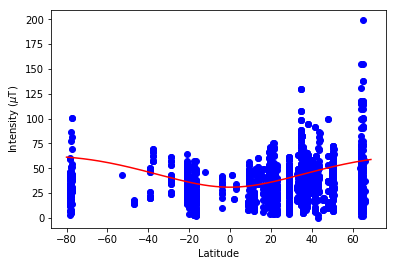

In [13]:
plt.plot(site_ages.lat,site_ages.int_abs*1e6,'bo')

# put on the expected values for the present dipole moment (~80 ZAm^2)

lats=np.arange(-80,70,1)
vdms=80e21*np.ones(len(lats))
bs=pmag.vdm_b(vdms,lats)*1e6
plt.plot(lats,bs,'r-')
plt.xlabel('Latitude')
plt.ylabel('Intensity ($\mu$T)')
plt.show()

That is pretty awful agreement.  Someday we need to figure out what is wrong with the data or  our GAD hypothesis.  

### grab_magic_key

[\[MagIC Database\]](https://earthref.org/MagIC) [\[command line version\]](https://pmagpy.github.io/PmagPy-cli.html#grab_magic_key.py)

Sometimes you want to read in a MagIC file and print out the desired key. **Pandas** makes this easy!  In this example, we will print out latitudes for each site record.

In [14]:
sites=pd.read_csv('data_files/download_magic/sites.txt',sep='\t',header=1)
print (sites.lat)

0     42.60264
1     42.60264
2     42.60260
3     42.60352
4     42.60350
5     42.60104
6     42.60100
7     42.73656
8     42.73660
9     42.84180
10    42.84180
11    42.86570
12    42.86570
13    42.92031
14    42.92030
15    42.56857
16    42.49964
17    42.49962
18    42.49960
19    42.50001
20    42.50000
21    42.52872
22    42.52870
23    42.45559
24    42.45560
25    42.48923
26    42.48920
27    42.46186
28    42.46190
29    42.69156
30    42.65289
31    42.65290
32    43.30504
33    43.30500
34    43.36817
35    43.36817
36    43.36820
37    43.42133
38    43.42130
39    43.88590
40    43.88590
41    43.88590
42    43.84273
43    43.84270
44    43.53289
45    43.57494
46    43.57494
47    43.57490
48    44.15663
49    44.15660
50    44.18629
51    42.60260
Name: lat, dtype: float64


### magic_select

[\[MagIC Database\]](https://earthref.org/MagIC) [\[command line version\]](https://pmagpy.github.io/PmagPy-cli.html#magic_select.py)

This example demonstrates how to select MagIC records that meet a certain criterion, like having a particular method code.

Note:  to output into a MagIC formatted file, we can change the DataFrame to a list of dictionaries (with df.to_dict("records")) and
use **pmag.magic_write()**.. 

In [15]:
help(pmag.magic_write)

Help on function magic_write in module pmagpy.pmag:

magic_write(ofile, Recs, file_type)
    Parameters
    _________
    ofile : path to output file
    Recs : list of dictionaries in MagIC format
    file_type : MagIC table type (e.g., specimens)
    
    Return :
    [True,False] : True if successful
    ofile : same as input
    
    Effects :
        writes a MagIC formatted file from Recs



In [16]:
# read in the data file
spec_df=pd.read_csv('data_files/magic_select/specimens.txt',sep='\t',header=1)
# pick out the desired data 
method_key='method_codes' # change to method_codes for data model 3
spec_df=spec_df[spec_df.method_codes.str.contains('LP-DIR-AF')]
specs=spec_df.to_dict('records') # export to list of dictionaries
success,ofile=pmag.magic_write('data_files/magic_select/AF_specimens.txt',specs,'pmag_specimens') # specimens for data model 3.0


76  records written to file  data_files/magic_select/AF_specimens.txt


### sites_extract

It is frequently desirable to format tables for publications from the MagIC formatted files.  This example is for the sites.txt formatted file.  It will create a site information table with the location and age information,  and directions and/or intenisty summary tables.  The function to call is **ipmag.sites_extract()**.

In [17]:
help(ipmag.sites_extract)

Help on function sites_extract in module pmagpy.ipmag:

sites_extract(site_file='sites.txt', directions_file='directions.xls', intensity_file='intensity.xls', info_file='site_info.xls', output_dir_path='.', input_dir_path='', latex=False)
    Extracts directional and/or intensity data from a MagIC 3.0 format sites.txt file.
    Default output format is an Excel file.
    Optional latex format longtable file which can be uploaded to Overleaf or
    typeset with latex on your own computer.
    
    Parameters
    ___________
    site_file : str
         input file name
    directions_file : str
          output file name for directional data
    intensity_file : str
          output file name for intensity data
    site_info : str
          output file name for site information (lat, lon, location, age....)
    output_dir_path : str
          path for output files
    input_dir_path : str
          path for intput file if different from output_dir_path (default is same)
    latex : boole

Here is an example for how to create Latex files: 

In [18]:
#latex way:
ipmag.sites_extract(directions_file='directions.tex',intensity_file='intensities.tex',
              output_dir_path='data_files/3_0/McMurdo',info_file='site_info.tex',latex=True)

(True,
 ['/Users/nebula/Python/PmagPy/data_files/3_0/McMurdo/site_info.tex',
  '/Users/nebula/Python/PmagPy/data_files/3_0/McMurdo/intensities.tex',
  '/Users/nebula/Python/PmagPy/data_files/3_0/McMurdo/directions.tex'])

And here is how to create Excel files:

In [19]:
#xls way:
if has_xlwt:
    print(ipmag.sites_extract(output_dir_path='data_files/3_0/McMurdo'))

(True, ['/Users/nebula/Python/PmagPy/data_files/3_0/McMurdo/site_info.xls', '/Users/nebula/Python/PmagPy/data_files/3_0/McMurdo/intensity.xls', '/Users/nebula/Python/PmagPy/data_files/3_0/McMurdo/directions.xls'])


### criteria_extract

This example is for the criteria.txt formatted file.  It will create a criteria  table suitable for publication in either LaTex or .csv format.  The function to call is **ipmag.criteria_extract()**.

In [20]:
help(ipmag.criteria_extract)

Help on function criteria_extract in module pmagpy.ipmag:

criteria_extract(crit_file='criteria.txt', output_file='criteria.xls', output_dir_path='.', input_dir_path='', latex=False)
    Extracts criteria  from a MagIC 3.0 format criteria.txt file.
    Default output format is an Excel file.
    typeset with latex on your own computer.
    
    Parameters
    ___________
    crit_file : str, default "criteria.txt"
         input file name
    output_file : str, default "criteria.xls"
         output file name
    output_dir_path : str, default "."
        output file directory
    input_dir_path : str, default ""
          path for intput file if different from output_dir_path (default is same)
    latex : boolean, default False
           if True, output file should be latex formatted table with a .tex ending
    
    Return :
        [True,False],  data table error type : True if successful
    
    Effects :
        writes xls or latex formatted tables for use in publications



In [21]:
# latex way:
ipmag.criteria_extract(output_dir_path='data_files/3_0/Megiddo',
                       latex=True,output_file='criteria.tex',)

(True, ['/Users/nebula/Python/PmagPy/data_files/3_0/Megiddo/criteria.tex'])

In [22]:
#xls way:
if has_xlwt:
    print(ipmag.criteria_extract(output_dir_path='data_files/3_0/Megiddo'))

(True, ['/Users/nebula/Python/PmagPy/data_files/3_0/Megiddo/criteria.xls'])


### specimens_extract

Similarly, it is useful to make tables for specimen (intensity) data to include in publications.  Here are examples using a specimens.txt file.  

In [23]:
help(ipmag.specimens_extract)

Help on function specimens_extract in module pmagpy.ipmag:

specimens_extract(spec_file='specimens.txt', output_file='specimens.xls', landscape=False, longtable=False, output_dir_path='.', input_dir_path='', latex=False)
    Extracts specimen results  from a MagIC 3.0 format specimens.txt file.
    Default output format is an Excel file.
    typeset with latex on your own computer.
    
    Parameters
    ___________
    spec_file : str, default "specimens.txt"
         input file name
    output_file : str, default "specimens.xls"
         output file name
    landscape : boolean, default False
           if True output latex landscape table
    longtable : boolean
           if True output latex longtable
    output_dir_path : str, default "."
        output file directory
    input_dir_path : str, default ""
          path for intput file if different from output_dir_path (default is same)
    latex : boolean, default False
           if True, output file should be latex formatted t

In [113]:
#latex way:
ipmag.specimens_extract(output_file='specimens.tex',landscape=True,
              output_dir_path='data_files/3_0/Megiddo',latex=True,longtable=True)

(True, ['/Users/nebula/Python/PmagPy/data_files/3_0/Megiddo/specimens.tex'])

In [25]:
#xls way:
if has_xlwt:
    print(ipmag.specimens_extract(output_dir_path='data_files/3_0/Megiddo'))

(True, ['/Users/nebula/Python/PmagPy/data_files/3_0/Megiddo/specimens.xls'])


## Contributions

Here are some useful functions for working with MagIC data model 3.0 contributions. 

### download_magic

[\[MagIC Database\]](https://earthref.org/MagIC)  [\[command line version\]](https://pmagpy.github.io/PmagPy-cli.html#download_magic.py)

 This program unpacks the .txt files downloaded from the MagIC database into individual text files. It has an option to also separate the contribution into separate folders for each location.
 
 As an example, go to the MagIC data base at http://earthref.org/MAGIC/doi/10.1029/2003gc000661 and download the contribution.    Make a folder into which you should put the downloaded txt file called MagIC_download and move the file into it. Now use **ipmag.download_magic** to unpack the .txt file (magic_contribution_16533.txt).

Here is an example.

In [26]:
help(ipmag.download_magic)

Help on function download_magic in module pmagpy.ipmag:

download_magic(infile, dir_path='.', input_dir_path='', overwrite=False, print_progress=True, data_model=3.0, separate_locs=False)
    takes the name of a text file downloaded from the MagIC database and
    unpacks it into magic-formatted files. by default, download_magic assumes
    that you are doing everything in your current directory. if not, you may
    provide optional arguments dir_path (where you want the results to go) and
    input_dir_path (where the downloaded file is IF that location is different from
    dir_path).
    
    Parameters
    ----------
    infile : str
        MagIC-format file to unpack
    dir_path : str
        output directory (default ".")
    input_dir_path : str, default ""
        path for intput file if different from output_dir_path (default is same)
    overwrite: bool
        overwrite current directory (default False)
    print_progress: bool
        verbose output (default True)
    dat

In [27]:
ipmag.download_magic(infile='magic_contribution_16533.txt',\
                     input_dir_path='data_files/download_magic',dir_path='data_files/download_magic')

working on:  'contribution'
1  records written to file  /Users/nebula/Python/PmagPy/data_files/download_magic/contribution.txt
contribution  data put in  /Users/nebula/Python/PmagPy/data_files/download_magic/contribution.txt
working on:  'locations'
3  records written to file  /Users/nebula/Python/PmagPy/data_files/download_magic/locations.txt
locations  data put in  /Users/nebula/Python/PmagPy/data_files/download_magic/locations.txt
working on:  'sites'
52  records written to file  /Users/nebula/Python/PmagPy/data_files/download_magic/sites.txt
sites  data put in  /Users/nebula/Python/PmagPy/data_files/download_magic/sites.txt
working on:  'samples'
271  records written to file  /Users/nebula/Python/PmagPy/data_files/download_magic/samples.txt
samples  data put in  /Users/nebula/Python/PmagPy/data_files/download_magic/samples.txt
working on:  'specimens'
225  records written to file  /Users/nebula/Python/PmagPy/data_files/download_magic/specimens.txt
specimens  data put in  /Users/neb

True

You could look at these data with **dmag_magic** for example... (see the **PmagPy_plots_analysis** notebook).

### upload_magic

[\[MagIC Database\]](https://earthref.org/MagIC)  [\[command line version\]](https://pmagpy.github.io/PmagPy-cli.html#upload_magic.py)

We can just turn around and try to upload the file downloaded in [download_magic](#download_magic).  For this we use **ipmag.upload_magic()** in the same directory as for the download.   You can try to upload the file you create to the MagIC data base as a private contribution here: https://www2.earthref.org/MagIC/upload



In [28]:
help(ipmag.upload_magic)

Help on function upload_magic in module pmagpy.ipmag:

upload_magic(concat=False, dir_path='.', dmodel=None, vocab='', contribution=None, input_dir_path='')
    Finds all magic files in a given directory, and compiles them into an
    upload.txt file which can be uploaded into the MagIC database.
    Parameters
    ----------
    concat : boolean where True means do concatenate to upload.txt file in dir_path,
        False means write a new file (default is False)
    dir_path : string for input/output directory (default ".")
    dmodel : pmagpy data_model.DataModel object,
        if not provided will be created (default None)
    vocab : pmagpy controlled_vocabularies3.Vocabulary object,
        if not provided will be created (default None)
    contribution : pmagpy contribution_builder.Contribution object, if not provided will be created
        in directory (default None)
    input_dir_path : str, default ""
        path for intput files if different from output dir_path (default 

In [29]:
ipmag.upload_magic(dir_path='data_files/download_magic',concat=True)

-I- Removing old error files from /Users/nebula/Python/PmagPy/data_files/download_magic: locations_errors.txt, samples_errors.txt, specimens_errors.txt, sites_errors.txt, ages_errors.txt, measurements_errors.txt, criteria_errors.txt, contribution_errors.txt, images_errors.txt
-W- Column 'core_depth' isn't in samples table, skipping it
-W- Column 'composite_depth' isn't in samples table, skipping it
-W- Invalid or missing column names, could not propagate columns
-I- ages file successfully read in
-I- Validating ages
-I- No row errors found!
-I- appending ages data to /Users/nebula/Python/PmagPy/data_files/download_magic/upload.txt
-I- 20 records written to ages file
-I- ages written to  /Users/nebula/Python/PmagPy/data_files/download_magic/upload.txt
-I- contribution file successfully read in
-I- dropping these columns: version from the contribution table
-I- Validating contribution
-I- No row errors found!
-I- appending contribution data to /Users/nebula/Python/PmagPy/data_files/downl

('/Users/nebula/Python/PmagPy/data_files/download_magic/Snake-River_06.May.2019.txt',
 '',
 None,
 None)

If this were your own study, you could now go to https://earthref.org/MagIC and upload your contribution to a Private Workspace, validate, assign a DOI and activate!  

### cb.add_sites_to_meas_table

MagIC data model 3 took out redundant columns in the MagIC tables so the hierarchy of specimens (in the measurements and specimens tables) up to samples, sites and locations is lost.  To put these back into the measurement table, we have the function **cb.add_sites_to_meas_table()**, which is super handy when data analysis requires it.  

In [30]:
help(cb.add_sites_to_meas_table)

Help on function add_sites_to_meas_table in module pmagpy.contribution_builder:

add_sites_to_meas_table(dir_path)
    Add site columns to measurements table (e.g., to plot intensity data),
    or generate an informative error message.
    
    Parameters
    ----------
    dir_path : str
        directory with data files
    
    
    Returns
    ----------
    status : bool
        True if successful, else False
    data : pandas DataFrame
        measurement data with site/sample



In [31]:
status,meas_df=cb.add_sites_to_meas_table('data_files/3_0/McMurdo')
meas_df.columns

Index(['experiment', 'specimen', 'measurement', 'dir_csd', 'dir_dec',
       'dir_inc', 'hyst_charging_mode', 'hyst_loop', 'hyst_sweep_rate',
       'treat_ac_field', 'treat_ac_field_dc_off', 'treat_ac_field_dc_on',
       'treat_ac_field_decay_rate', 'treat_dc_field', 'treat_dc_field_ac_off',
       'treat_dc_field_ac_on', 'treat_dc_field_decay_rate',
       'treat_dc_field_phi', 'treat_dc_field_theta', 'treat_mw_energy',
       'treat_mw_integral', 'treat_mw_power', 'treat_mw_time',
       'treat_step_num', 'treat_temp', 'treat_temp_dc_off', 'treat_temp_dc_on',
       'treat_temp_decay_rate', 'magn_mass', 'magn_moment', 'magn_volume',
       'citations', 'instrument_codes', 'method_codes', 'quality', 'standard',
       'meas_field_ac', 'meas_field_dc', 'meas_freq', 'meas_n_orient',
       'meas_orient_phi', 'meas_orient_theta', 'meas_pos_x', 'meas_pos_y',
       'meas_pos_z', 'meas_temp', 'meas_temp_change', 'analysts',
       'description', 'software_packages', 'timestamp', 'magn_r2

### cb.get_intensity_col

The MagIC data model has several different forms of magnetization with different normalizations (moment, volume, or mass).  So to find the one used in a particular measurements table we can use this handy function.  

In [32]:
help(cb.get_intensity_col)

Help on function get_intensity_col in module pmagpy.contribution_builder:

get_intensity_col(data)
    Check measurement dataframe for intensity columns 'magn_moment', 'magn_volume', 'magn_mass','magn_uncal'.
    Return the first intensity column that is in the dataframe AND has data.
    
    Parameters
    ----------
    data : pandas DataFrame
    
    Returns
    ---------
    str
        intensity method column or ""



In [33]:
magn_col=cb.get_intensity_col(meas_df)
print (magn_col)

magn_moment


# Conversion Scripts

## convert_2_magic

We imported this module as **convert**.  It provides many functions for creating MagIC format files from non-MagIC formats. The MagIC formatted files can then be used with PmagPy programs and uploaded to the MagIC database. Let's take a look at the options:



### \_2g\_asc\_magic

This conversion has not been written yet. If you have this file format and wish to convert it to the MagIC file format, please let us know.

### \_2g\_bin\_magic

[\[MagIC Database\]](https://earthref.org/MagIC)  [\[command line version\]](https://pmagpy.github.io/PmagPy-cli.html#_2g_bin_magic.py)

To convert the binary formatted 2G Enterprises measurement files, we  can use the function **convert.\_2g_bin()** in the **convert_2_magic** module (imported as **convert**). 

In [34]:
help(convert._2g_bin)

Help on function _2g_bin in module pmagpy.convert_2_magic:

_2g_bin(dir_path='.', mag_file='', meas_file='measurements.txt', spec_file='specimens.txt', samp_file='samples.txt', site_file='sites.txt', loc_file='locations.txt', or_con='3', specnum=0, samp_con='2', corr='1', gmeths='FS-FD:SO-POM', location='unknown', inst='', user='', noave=False, input_dir='', lat='', lon='')
     Convert 2G binary format file to MagIC file(s)
    
     Parameters
     ----------
     dir_path : str
         output directory, default "."
     mag_file : str
         input file name
     meas_file : str
         output measurement file name, default "measurements.txt"
     spec_file : str
         output specimen file name, default "specimens.txt"
     samp_file: str
         output sample file name, default "samples.txt"
     site_file : str
         output site file name, default "sites.txt"
     loc_file : str
         output location file name, default "locations.txt"
     or_con : number
         ori

In [35]:
# set the input directory
input_dir='data_files/convert_2_magic/2g_bin_magic/mn1/'
mag_file='mn001-1a.dat'
convert._2g_bin(mag_file=mag_file,input_dir=input_dir,dir_path=input_dir)

importing  mn001-1a
-I- writing specimens records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/2g_bin_magic/mn1/specimens.txt
-I- 1 records written to specimens file
-I- writing samples records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/2g_bin_magic/mn1/samples.txt
-I- 1 records written to samples file
-I- writing sites records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/2g_bin_magic/mn1/sites.txt
-I- 1 records written to sites file
-I- writing locations records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/2g_bin_magic/mn1/locations.txt
-I- 1 records written to locations file
-I- writing measurements records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/2g_bin_magic/mn1/measurements.txt
-I- 19 records written to measurements file


(True, 'measurements.txt')

These are measurement data for a single specimen, so we can take a quickie look at the data in an equal area projection.

In [36]:
help(ipmag.plot_di)

Help on function plot_di in module pmagpy.ipmag:

plot_di(dec=None, inc=None, di_block=None, color='k', marker='o', markersize=20, legend='no', label='', title='', edge='', alpha=1)
    Plot declination, inclination data on an equal area plot.
    
    Before this function is called a plot needs to be initialized with code that looks
    something like:
    >fignum = 1
    >plt.figure(num=fignum,figsize=(10,10),dpi=160)
    >ipmag.plot_net(fignum)
    
    Required Parameters
    -----------
    dec : declination being plotted
    inc : inclination being plotted
    
    or
    
    di_block: a nested list of [dec,inc,1.0]
    (di_block can be provided instead of dec, inc in which case it will be used)
    
    Optional Parameters (defaults are used if not specified)
    -----------
    color : the default color is black. Other colors can be chosen (e.g. 'r')
    marker : the default marker is a circle ('o')
    markersize : default size is 20
    label : the default label is blank (''

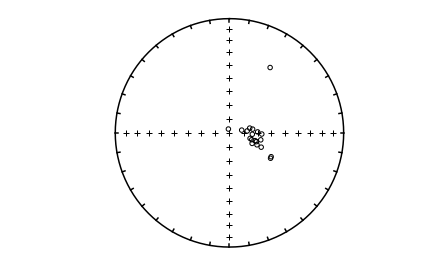

In [37]:
meas_df=pd.read_csv(input_dir+'measurements.txt',sep='\t',header=1)
ipmag.plot_net(1)
ipmag.plot_di(dec=meas_df['dir_dec'],inc=meas_df['dir_inc'])

### agm_magic

[\[MagIC Database\]](https://earthref.org/MagIC)  [\[command line version\]](https://pmagpy.github.io/PmagPy-cli.html#agm_magic.py)

 This program converts Micromag hysteresis files into MagIC formatted files. Because this program creates files for uploading to the MagIC database, specimens should also have sample/site/location information, which can be provided on the command line. If this information is not available, for example if this is a synthetic specimen, specify syn= True for synthetic name. 

Someone named Lima Tango has measured a synthetic specimen named myspec for hysteresis and saved the data in a file named agm_magic_example.agm in the agm_magic/agm_directory folder. The backfield IRM curve for the same specimen was saved in same directory as agm_magic_example.irm. Use the function **convert.agm()** to convert the data into a measurements.txt output file. For the backfield IRM file, set the keyword "bak" to True.  These were measured using cgs units, so be sure to set the units key word argument properly. Combine the two output files together using the instructions for [combine_magic](#combine_magic).  The agm files can be plotted using [hysteresis_magic](#hysteresis_magic) but the back-field plots are broken.  



In [38]:
help(convert.agm)

Help on function agm in module pmagpy.convert_2_magic:

agm(agm_file, dir_path='.', input_dir_path='', meas_outfile='', spec_outfile='', samp_outfile='', site_outfile='', loc_outfile='', spec_infile='', samp_infile='', site_infile='', specimen='', specnum=0, samp_con='1', location='unknown', instrument='', institution='', bak=False, syn=False, syntype='', units='cgs', fmt='new', user='')
    Convert AGM format file to MagIC file(s)
    
    Parameters
    ----------
    agm_file : str
        input file name
    dir_path : str
        working directory, default "."
    input_dir_path : str
        input file directory IF different from dir_path, default ""
    meas_outfile : str
        output measurement file name, default ""
        (default output is SPECNAME.magic)
    spec_outfile : str
        output specimen file name, default ""
        (default output is SPEC_specimens.txt)
    samp_outfile: str
        output sample file name, default ""
        (default output is SPEC_sample

In [39]:
convert.agm('agm_magic_example.agm',dir_path='data_files/convert_2_magic/agm_magic/',
            specimen='myspec',fmt='old',meas_outfile='agm.magic')

-I- writing specimens records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/agm_magic/myspec_specimens.txt
-I- 1 records written to specimens file
-I- writing samples records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/agm_magic/samples.txt
-I- 1 records written to samples file
-I- writing sites records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/agm_magic/sites.txt
-I- 1 records written to sites file
-I- writing locations records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/agm_magic/myspec_locations.txt
-I- 1 records written to locations file
-I- writing measurements records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/agm_magic/agm.magic
-I- 284 records written to measurements file


(True, 'agm.magic')

In [40]:
convert.agm('agm_magic_example.irm',dir_path='data_files/convert_2_magic/agm_magic/',
            specimen='myspec',fmt='old',meas_outfile='irm.magic')

-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/agm_magic/myspec_specimens.txt
-I- 1 records written to specimens file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/agm_magic/samples.txt
-I- 1 records written to samples file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/agm_magic/sites.txt
-I- 1 records written to sites file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/agm_magic/myspec_locations.txt
-I- 1 records written to locations file
-I- writing measurements records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/agm_magic/irm.magic
-I- 41 records written to measurements file


(True, 'irm.magic')

In [41]:
infiles=['data_files/convert_2_magic/agm_magic/agm.magic','data_files/convert_2_magic/agm_magic/irm.magic']
ipmag.combine_magic(infiles,'data_files/convert_2_magic/agm_magic/measurements.txt')

-I- writing measurements records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/agm_magic/measurements.txt
-I- 325 records written to measurements file


'/Users/nebula/Python/PmagPy/data_files/convert_2_magic/agm_magic/measurements.txt'

We can look at these data using **hysteresis_magic**:

myspec : 
 {'hysteresis_xhf': '1.77e-05', 'hysteresis_ms_moment': '2.914e+01', 'hysteresis_mr_moment': '5.493e+00', 'hysteresis_bc': '2.195e-02', 'hysteresis_bcr': '6.702e-02', 'magic_method_codes': 'LP-BCR-HDM', 'specimen': 'myspec'}


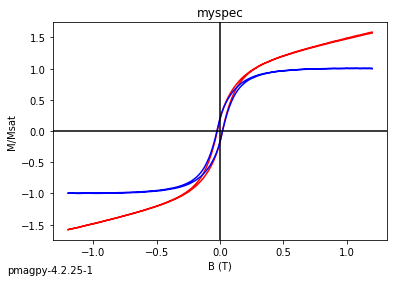

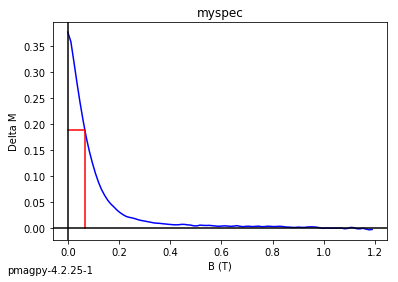

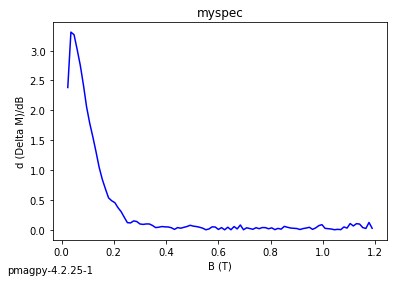

In [42]:
# read in the measurements data
meas_data=pd.read_csv('data_files/convert_2_magic/agm_magic/agm.magic',sep='\t',header=1)
# pick out the hysteresis data using the method code for hysteresis lab protocol
hyst_data=meas_data[meas_data.method_codes.str.contains('LP-HYS')]

# make the dictionary for figures that pmagplotlib likes

# make a list of specimens
specimens=hyst_data.specimen.unique()
cnt=1
for specimen in specimens:
    HDD={'hyst':cnt,'deltaM':cnt+1,'DdeltaM':cnt+2}
    spec_data=hyst_data[hyst_data.specimen==specimen]
# make a list of the field data
    B=spec_data.meas_field_dc.tolist()
# make a list o the magnetizaiton data
    M=spec_data.magn_moment.tolist()
# call the plotting function
    hpars=pmagplotlib.plot_hdd(HDD,B,M,specimen)
    hpars['specimen']=specimen
# print out the hysteresis parameters
    print (specimen,': \n',hpars)
    cnt+=3

### bgc_magic 

[\[MagIC Database\]](https://earthref.org/MagIC)  [\[command line version\]](https://pmagpy.github.io/PmagPy-cli.html#bgc_magic.py)

Here we convert the Berkeley Geochronology Center's AutoCore format to MagIC use **convert.bgc()**. 



In [43]:
help(convert.bgc)

Help on function bgc in module pmagpy.convert_2_magic:

bgc(mag_file, dir_path='.', input_dir_path='', meas_file='measurements.txt', spec_file='specimens.txt', samp_file='samples.txt', site_file='sites.txt', loc_file='locations.txt', append=False, location='unknown', site='', samp_con='1', specnum=0, meth_code='LP-NO', volume=12, user='', timezone='US/Pacific', noave=False)
    Convert BGC format file to MagIC file(s)
    
    Parameters
    ----------
    mag_file : str
        input file name
    dir_path : str
        working directory, default "."
    input_dir_path : str
        input file directory IF different from dir_path, default ""
    meas_file : str
        output measurement file name, default "measurements.txt"
    spec_file : str
        output specimen file name, default "specimens.txt"
    samp_file: str
        output sample file name, default "samples.txt"
    site_file : str
        output site file name, default "sites.txt"
    loc_file : str
        output locati

In [44]:
dir_path='data_files/convert_2_magic/bgc_magic/'
convert.bgc('15HHA1-2A',dir_path=dir_path)

mag_file in bgc_magic /Users/nebula/Python/PmagPy/data_files/convert_2_magic/bgc_magic/15HHA1-2A
-I- writing specimens records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/bgc_magic/specimens.txt
-I- 1 records written to specimens file
-I- writing samples records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/bgc_magic/samples.txt
-I- 1 records written to samples file
-I- writing sites records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/bgc_magic/sites.txt
-I- 1 records written to sites file
-I- writing locations records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/bgc_magic/locations.txt
-I- 1 records written to locations file
-I- writing measurements records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/bgc_magic/measurements.txt
-I- 21 records written to measurements file


(True,
 '/Users/nebula/Python/PmagPy/data_files/convert_2_magic/bgc_magic/measurements.txt')

And let's take a look

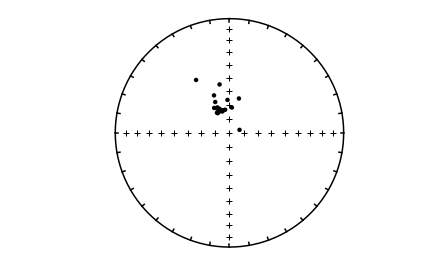

In [45]:
meas_df=pd.read_csv(dir_path+'measurements.txt',sep='\t',header=1)
ipmag.plot_net(1)
ipmag.plot_di(dec=meas_df['dir_dec'],inc=meas_df['dir_inc'])

### cit_magic

[\[MagIC Database\]](https://earthref.org/MagIC)  [\[command line version\]](https://pmagpy.github.io/PmagPy-cli.html#cit_magic.py)

To convert the CalTech format to MagIC, use **convert.cit()**. 

Craig Jones’ PaleoMag software package (http://cires.colorado.edu/people/jones.craig/PMag3.html) imports various file formats, including the ’CIT’ format developed for the Caltech lab and now used in magnetometer control software that ships with 2G magnetometers that utilized a vertical sample changer system. The documentation for the CIT sample format is here: http://cires.colorado.edu/people/jones.craig/PMag_Formats.html#SAM_format. Demagnetization data for each specimen are in their own file in a directory with all the data for a site or study. These files are strictly formatted with fields determined by the character number in the line. There must be a file with the suffix ‘.sam’ in the same directory as the specimen data files which gives details about the specimens and a list of the specimen measurementfiles in the directory. 

 The first line in the .sam file is a comment (in this case the site name), the second is the latitude and longitude followed by a declination correction. In these data, the declination correction was applied to the specimen orientations so the value of the declination correction is set to be 0.

For detailed description of the .sam and sample file formats, check the PaleoMag Formats website linked to above.


In [46]:
help(convert.cit)

Help on function cit in module pmagpy.convert_2_magic:

cit(dir_path='.', input_dir_path='', magfile='', user='', meas_file='measurements.txt', spec_file='specimens.txt', samp_file='samples.txt', site_file='sites.txt', loc_file='locations.txt', locname='unknown', sitename='', methods=['SO-MAG'], specnum=0, samp_con='3', norm='cc', oersted=False, noave=False, meas_n_orient='8', labfield=0, phi=0, theta=0)
    Converts CIT formated Magnetometer data into MagIC format for Analysis and contribution to the MagIC database
    
    Parameters
    -----------
    dir_path : directory to output files to (default : current directory)
    input_dir_path : directory to input files (only needed if different from dir_path!)
    magfile : magnetometer file (.sam) to convert to MagIC (required)
    user : colon delimited list of analysts (default : "")
    meas_file : measurement file name to output (default : measurements.txt)
    spec_file : specimen file name to output (default : specimens.txt)
   

Use the function **convert.cit()** to covert the CIT data files from Swanson-Hysell lab at Berkeley for the PI47 site in the data_files/convert_2_magic/cit_magic/PI47 directory. The site (PI47) was part of a data set published in Fairchild et al., (2016) (available in the MagIC database: (https://earthref.org/MagIC/11292/). The location name was “Slate Islands”, the naming convention was #2, the specimen name is specified with 1 character, we don’t wish to average replicate measurements  and they were collected by drilling and with a magnetic compass (”FS-FD",and "SO-MAG”). 

In [47]:
dir_path='data_files/convert_2_magic/cit_magic/PI47/'
convert.cit(dir_path=dir_path,
           magfile='PI47-.sam',locname="Slate Islands",specnum=1,samp_con='2',
           methods=['FS-FD','SO-MAG'],noave=True)

PI47-

-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/cit_magic/PI47/specimens.txt
-I- 9 records written to specimens file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/cit_magic/PI47/samples.txt
-I- 9 records written to samples file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/cit_magic/PI47/sites.txt
-I- 1 records written to sites file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/cit_magic/PI47/locations.txt
-I- 1 records written to locations file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/cit_magic/PI47/measurements.txt
-I- 266 records written to measurements file


(True, 'measurements.txt')

We can make some Zijderveld diagrams (see **zeq_magic** in the **PmagPy_plots_analysis** notebook). 

(True, [])

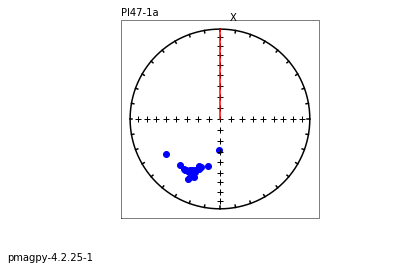

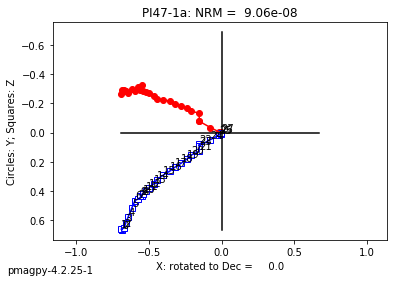

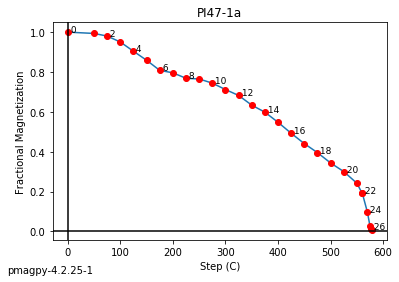

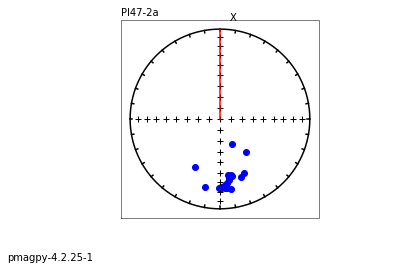

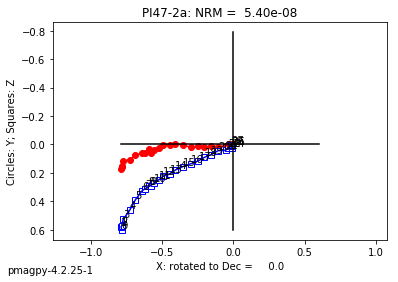

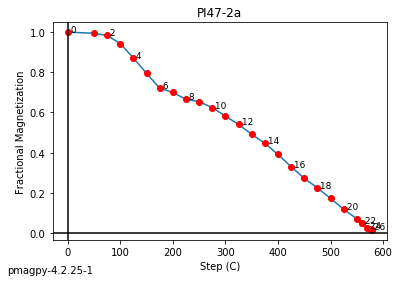

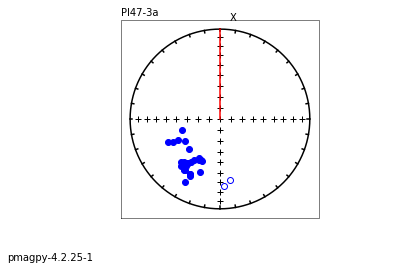

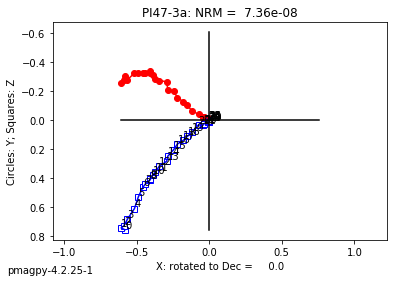

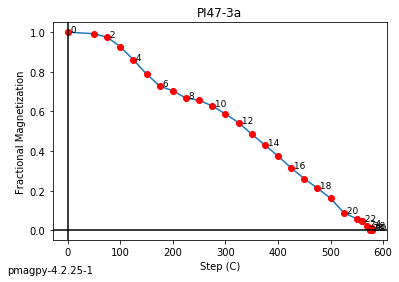

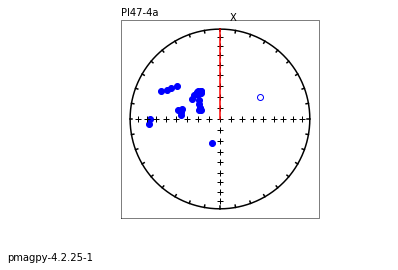

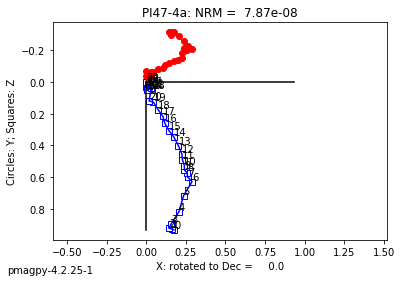

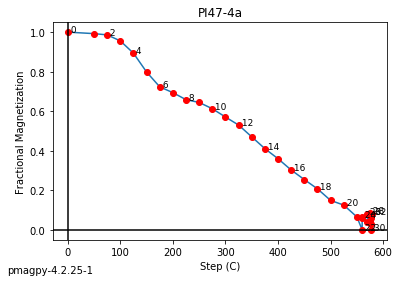

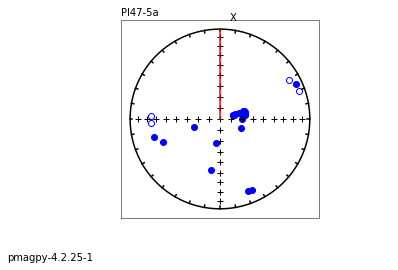

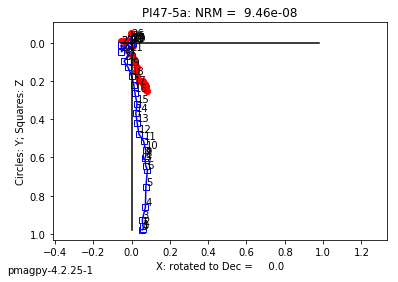

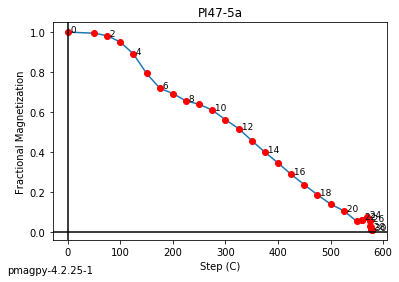

In [48]:
ipmag.zeq_magic(input_dir_path=dir_path, save_plots=False)

Use the function convert.cit() to covert the CIT data files from the USGS lab at Menlo Park. The data file is in the data_files/convert_2_magic/cit_magic/USGS/bl9-1 directory, the file name is bl9-1.sam, and the analyst was Hagstrum. The location name was “Boring volcanic field”, and this site name was set by Hagstrum to BL9001 because the site name cannot be determined from the sample name with the current available options. The samples were collected by drilling and with a magnetic compass and sun compass (”FS-FD",and "SO-MAG”), the measurement are in Oersted instead of the standard milliTesla, and we don’t wish to average replicate measurements.

In [49]:
dir_path='data_files/convert_2_magic/cit_magic/USGS/bl9-1'
convert.cit(dir_path=dir_path,
           magfile='bl9-1.sam',user='Hagstrum',locname="Boring volcanic field",
           sitename='BL9001',methods=['FS-FD','SO-SM','LT-AF-Z'], oersted=True,
           noave=True)

Boring Lava collection 2009

-I- writing specimens records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/cit_magic/USGS/bl9-1/specimens.txt
-I- 9 records written to specimens file
-I- writing samples records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/cit_magic/USGS/bl9-1/samples.txt
-I- 9 records written to samples file
-I- writing sites records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/cit_magic/USGS/bl9-1/sites.txt
-I- 1 records written to sites file
-I- writing locations records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/cit_magic/USGS/bl9-1/locations.txt
-I- 1 records written to locations file
-I- writing measurements records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/cit_magic/USGS/bl9-1/measurements.txt
-I- 63 records written to measurements file


(True, 'measurements.txt')

We can look at the Zijderveld, etc.  Diagrams with [zeq_magic](#zeq_magic).

(True, [])

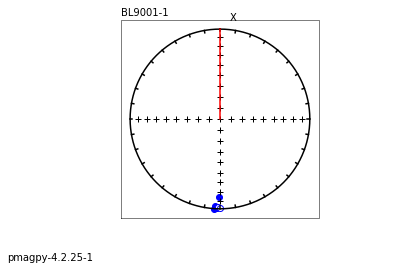

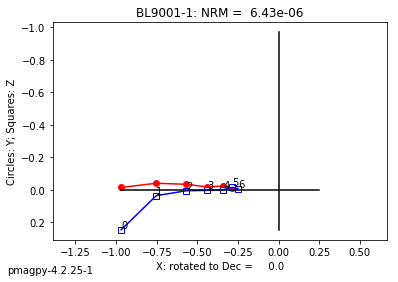

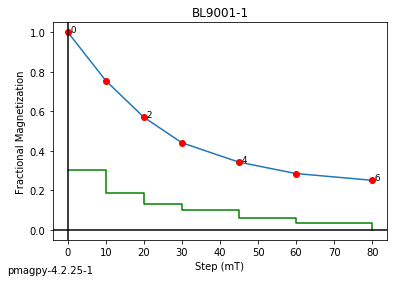

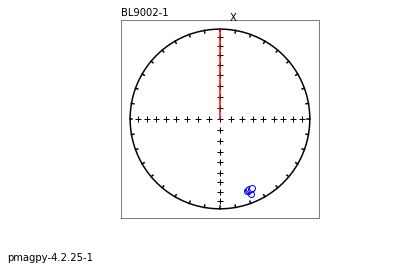

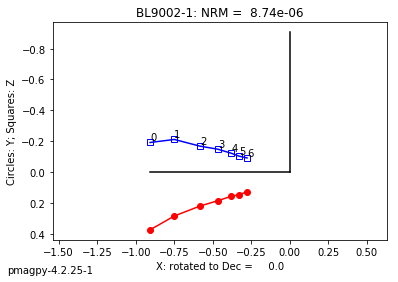

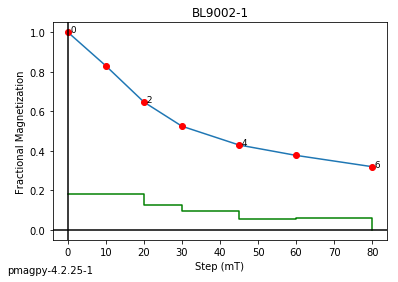

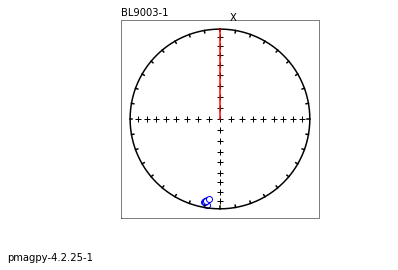

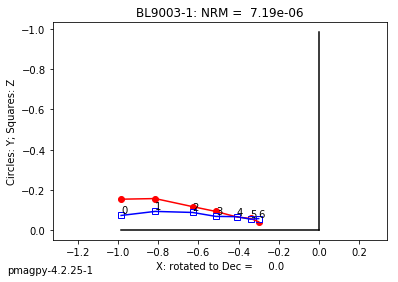

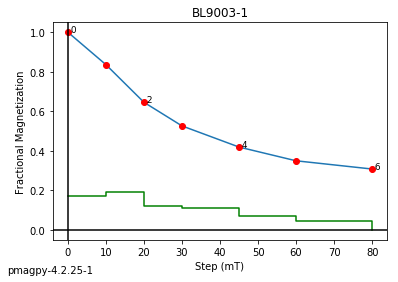

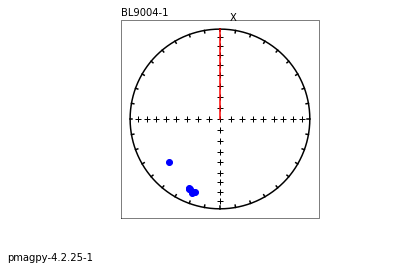

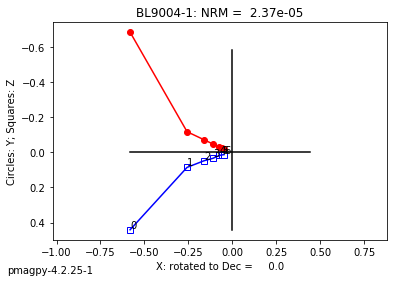

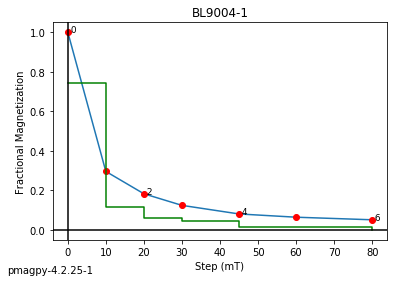

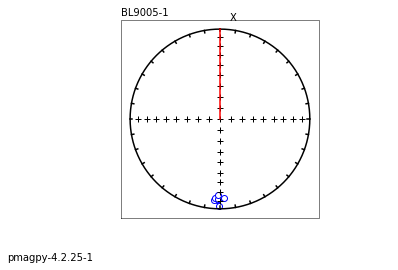

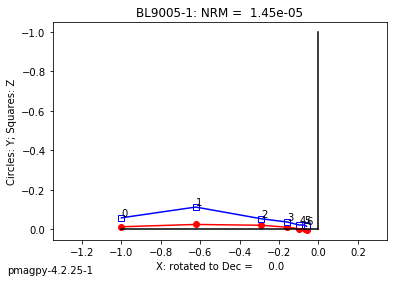

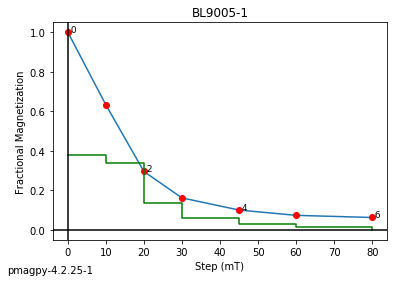

In [50]:
ipmag.zeq_magic(input_dir_path=dir_path, save_plots=False)

Use the function convert.cit() to convert the CIT data files from Ben Wiess's lab at MIT. This data was part of a set published in ESPL. "A nonmagnetic differentiated early planetary body", 
doi:10.1016/j.epsl.2017.03.026 The data can be found in MagIC at https://earthref.org/MagIC/11943

The data file is in the data_files/convert_2_magic/cit_magic/MIT/7325B directory, the file name is 7325B.sam, and the analyst was Wiess. The location name was “NWA 7325” with the site name coming from the sample name with the "1" convention. The samples are described with the method codes DE-VM, LP-DIR-T, LT-AF-Z, LT-NO, LT-T-Z, and SO-CMD-NORTH (see https://www2.earthref.org/MagIC/method-codes for full descriptions). We also don’t wish to average replicate measurements.

In [51]:
convert.cit(dir_path='data_files/convert_2_magic/cit_magic/MIT/7325B',
           magfile='7325B.sam',user='Wiess',locname="NWA 7325",samp_con='1',
           methods=['DE-VM', 'LP-DIR-T', 'LT-AF-Z', 'LT-NO', 'LT-T-Z', 'SO-CMD-NORTH'],
           noave=True)

NWA 7325 sample B7

-I- writing specimens records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/cit_magic/MIT/7325B/specimens.txt
-I- 9 records written to specimens file
-I- writing samples records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/cit_magic/MIT/7325B/samples.txt
-I- 9 records written to samples file
-I- writing sites records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/cit_magic/MIT/7325B/sites.txt
-I- 1 records written to sites file
-I- writing locations records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/cit_magic/MIT/7325B/locations.txt
-I- 1 records written to locations file
-I- writing measurements records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/cit_magic/MIT/7325B/measurements.txt
-I- 309 records written to measurements file


(True, 'measurements.txt')

And take a look see:

(True, [])

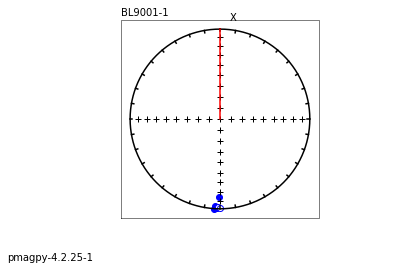

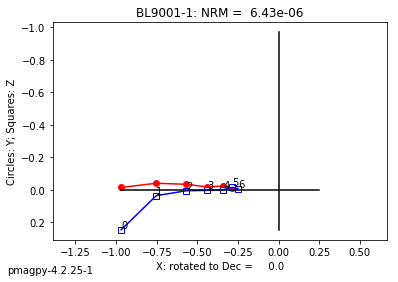

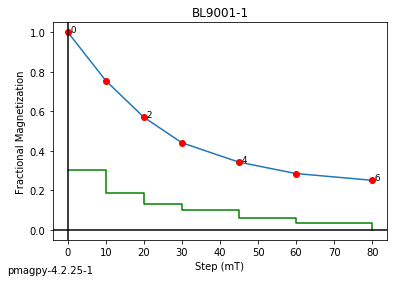

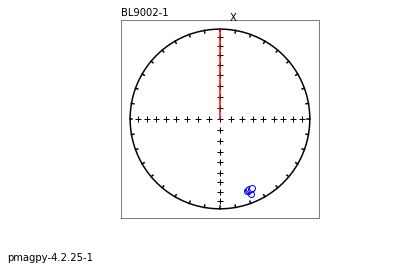

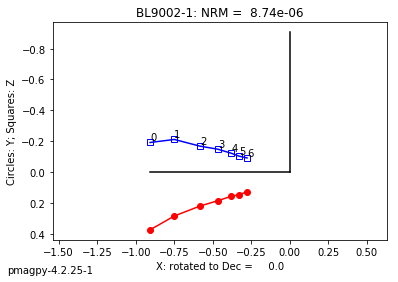

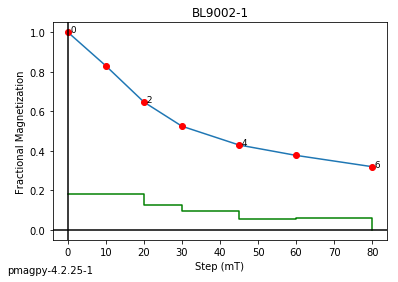

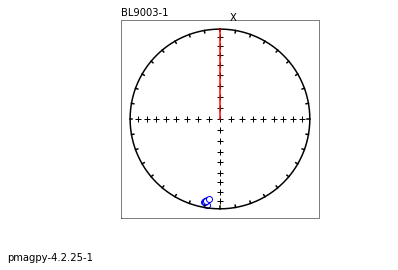

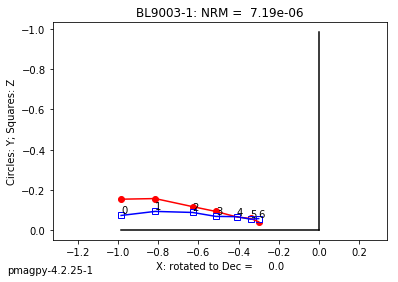

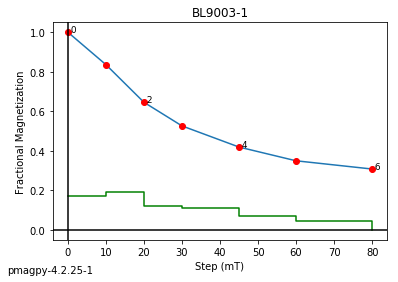

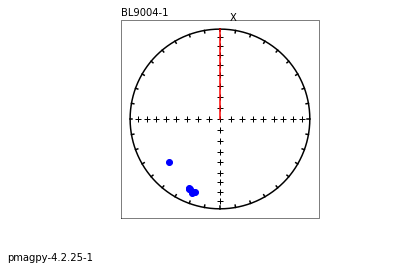

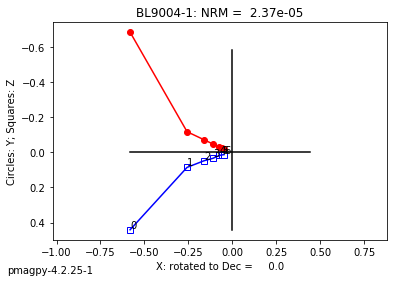

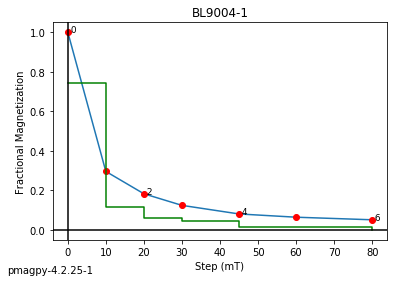

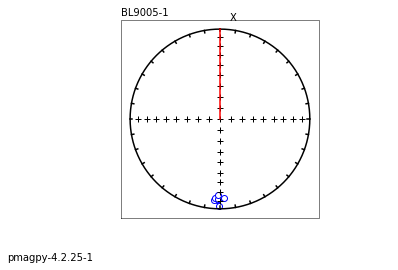

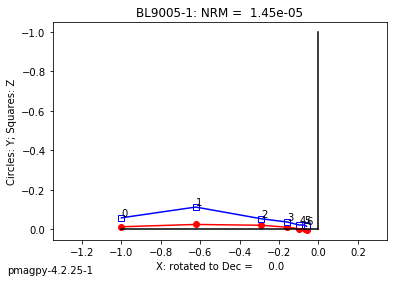

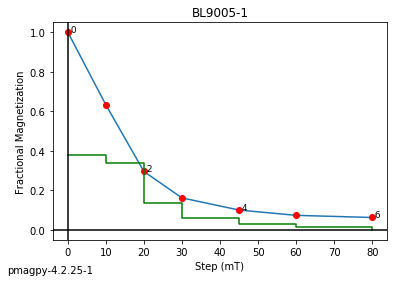

In [52]:
ipmag.zeq_magic(input_dir_path=dir_path, save_plots=False)

### generic_magic 

[\[MagIC Database\]](https://earthref.org/MagIC)  [\[command line version\]](https://pmagpy.github.io/PmagPy-cli.html#generic_magic.py)

If you have a data file format that is not supported, you can relabel column headers to fit the generic format as in the generic_magic example data file. 

To import the generic file format, use **convert.generic()**.


In [53]:
help(convert.generic)

Help on function generic in module pmagpy.convert_2_magic:

generic(magfile='', dir_path='.', meas_file='measurements.txt', spec_file='specimens.txt', samp_file='samples.txt', site_file='sites.txt', loc_file='locations.txt', user='', labfield=0, labfield_phi=0, labfield_theta=0, experiment='', cooling_times_list=[], sample_nc=[1, 0], site_nc=[1, 0], location='unknown', lat='', lon='', noave=False, input_dir_path='')
    Convert generic file to MagIC file(s)
    
    Parameters
    ----------
    mag_file : str
        input file name
    dir_path : str
        output directory, default "."
    meas_file : str
        output measurement file name, default "measurements.txt"
    spec_file : str
        output specimen file name, default "specimens.txt"
    samp_file: str
        output sample file name, default "samples.txt"
    site_file : str
        output site file name, default "sites.txt"
    loc_file : str
        output location file name, default "locations.txt"
    user : str
 

In [54]:
convert.generic(magfile='data_files/convert_2_magic/generic_magic/generic_magic_example.txt',
                experiment='PI',dir_path='data_files/convert_2_magic/generic_magic')

-I- writing specimens records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/generic_magic/specimens.txt
-I- 2 records written to specimens file
-I- writing samples records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/generic_magic/samples.txt
-I- 2 records written to samples file
-I- writing sites records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/generic_magic/sites.txt
-I- 2 records written to sites file
-I- writing locations records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/generic_magic/locations.txt
-I- 1 records written to locations file
-I- writing measurements records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/generic_magic/measurements.txt
-I- 23 records written to measurements file


(True, 'measurements.txt')

(True, [])

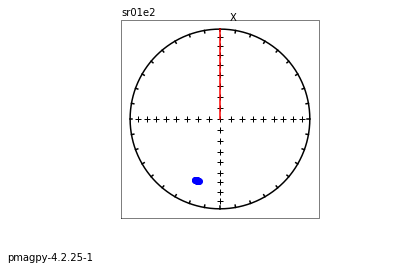

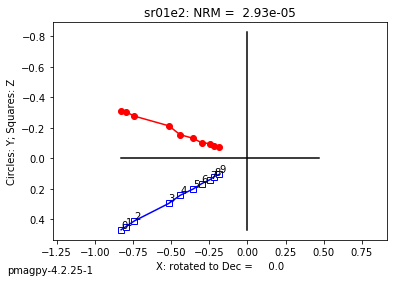

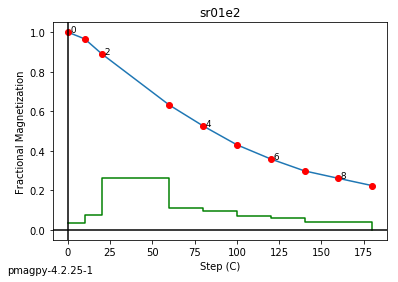

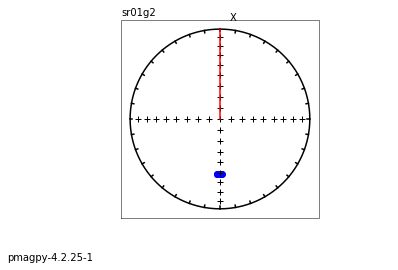

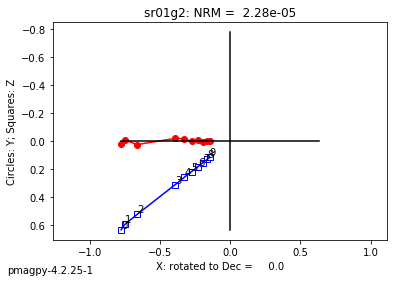

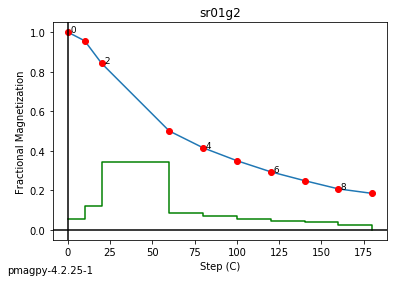

In [55]:
# let's take a look
dir_path='data_files/convert_2_magic/generic_magic/'
ipmag.zeq_magic(input_dir_path=dir_path, save_plots=False)

### huji_magic 

[\[MagIC Database\]](https://earthref.org/MagIC)  [\[command line version\]](https://pmagpy.github.io/PmagPy-cli.html#huji_magic.py)

To import the Hebrew University, Jerusalem, Israel file format to MagIC, use **convert.huji()**.   

In [56]:
help(convert.huji)

Help on function huji in module pmagpy.convert_2_magic:

huji(magfile='', dir_path='.', input_dir_path='', datafile='', codelist='', meas_file='measurements.txt', spec_file='specimens.txt', samp_file='samples.txt', site_file='sites.txt', loc_file='locations.txt', user='', specnum=0, samp_con='1', labfield=0, phi=0, theta=0, location='', CR_cooling_times=None, noave=False)
    Convert HUJI format file to MagIC file(s)
    
    Parameters
    ----------
    magfile : str
       input file name
    dir_path : str
        working directory, default "."
    input_dir_path : str
        input file directory IF different from dir_path, default ""
    datafile : str
       HUJI datafile with sample orientations, default ""
    codelist : str
        colon-delimited protocols, include all that apply
        see info below
    meas_file : str
        output measurement file name, default "measurements.txt"
    spec_file : str
        output specimen file name, default "specimens.txt"
    samp_fi

In [57]:
dir_path='data_files/convert_2_magic/huji_magic/'
convert.huji(dir_path=dir_path,
             magfile='Massada_AF_HUJI_new_format.txt',codelist='T')

-W- Identical treatments in file Massada_AF_HUJI_new_format.txt magfile line 818: specimen M5-119E, treatment 0 ignoring the first. 
-I- done reading file Massada_AF_HUJI_new_format.txt
-I- writing specimens records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/huji_magic/specimens.txt
-I- 56 records written to specimens file
-I- writing samples records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/huji_magic/samples.txt
-I- 56 records written to samples file
-I- writing sites records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/huji_magic/sites.txt
-I- 29 records written to sites file
-I- writing locations records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/huji_magic/locations.txt
-I- 1 records written to locations file
-I- writing measurements records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/huji_magic/measurements.txt
-I- 616 records written to measurements file


(True, 'measurements.txt')

(True, [])

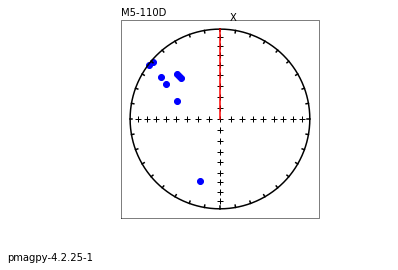

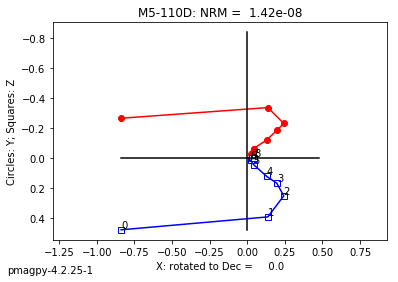

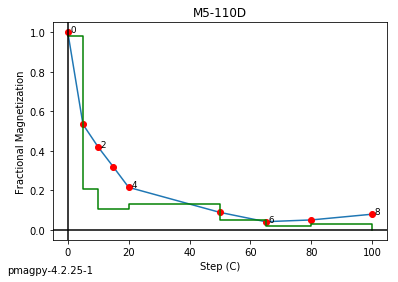

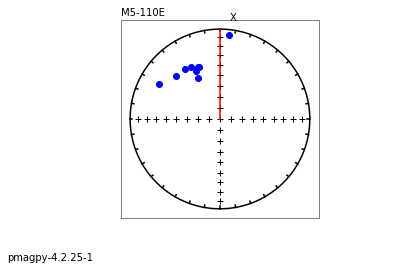

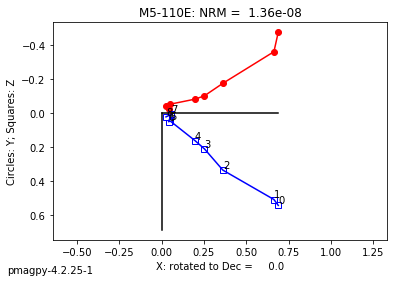

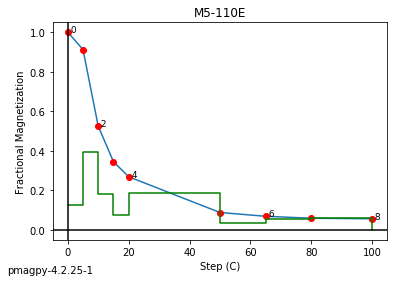

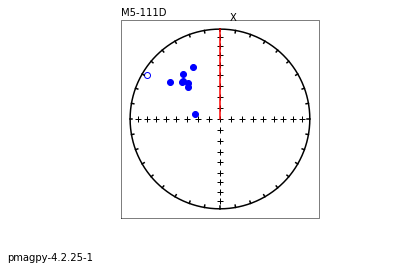

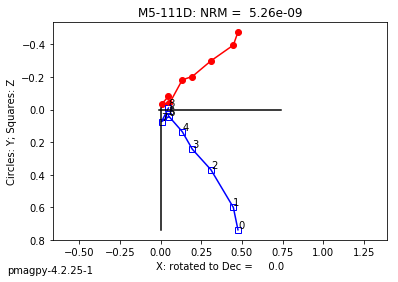

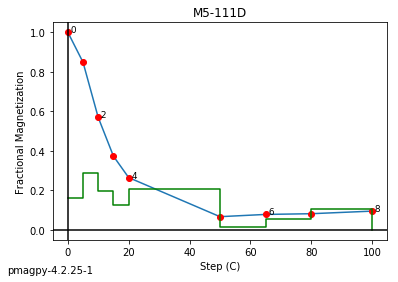

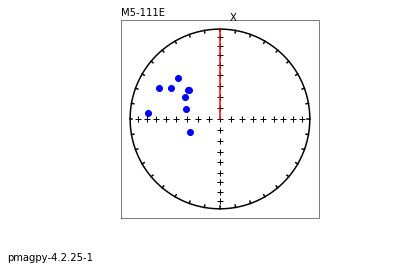

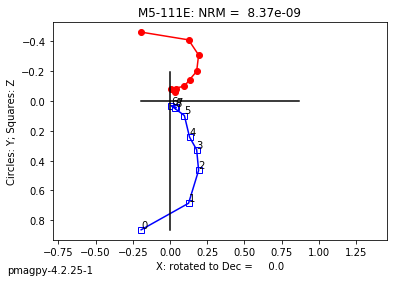

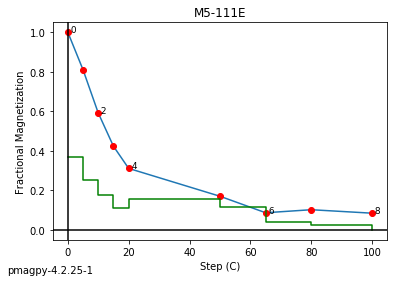

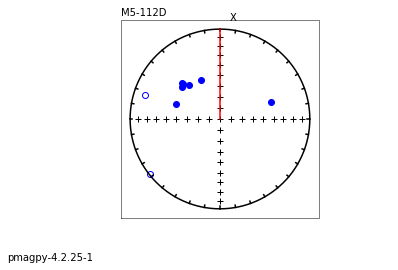

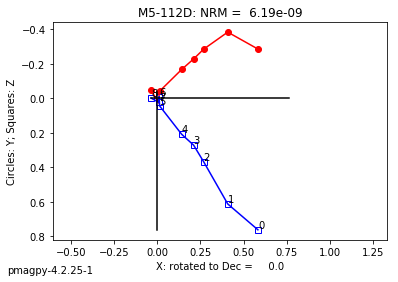

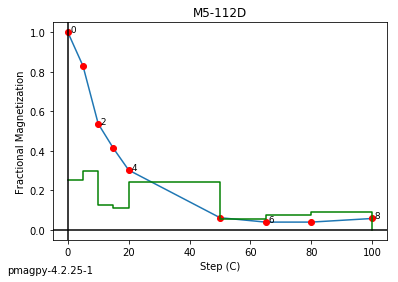

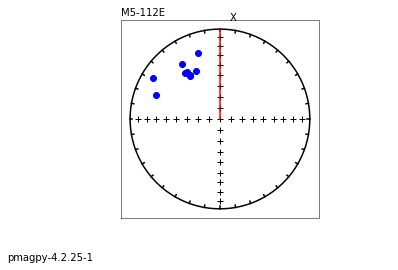

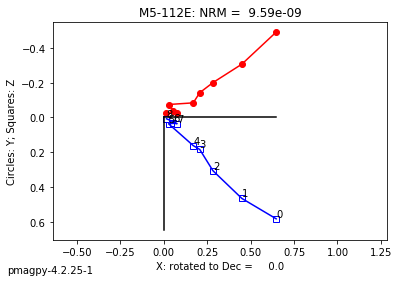

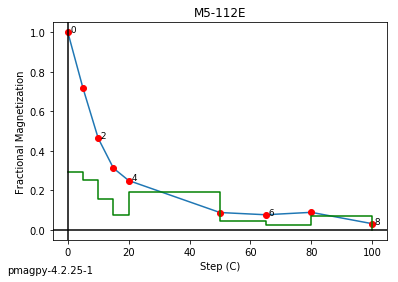

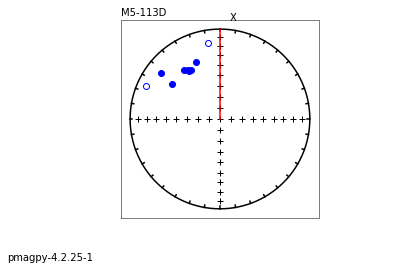

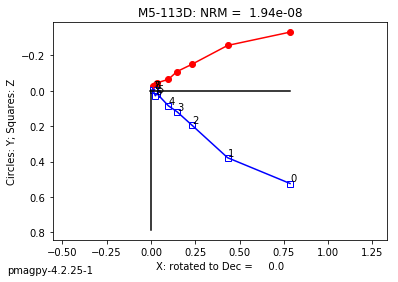

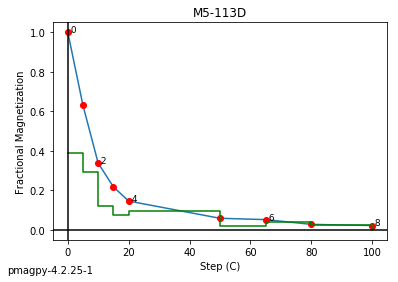

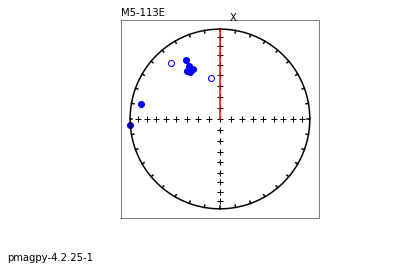

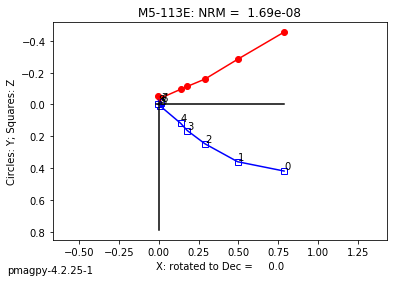

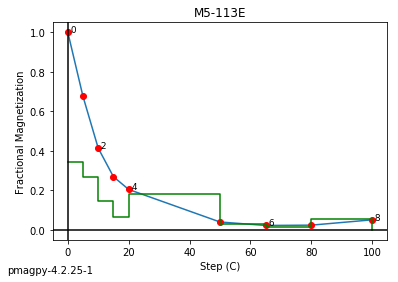

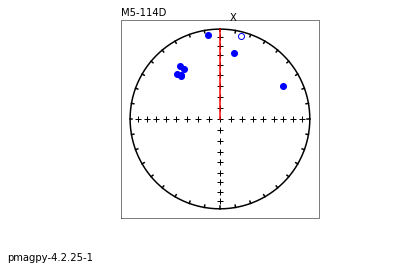

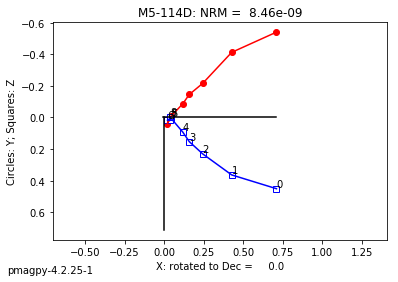

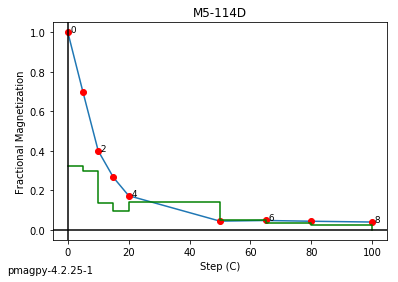

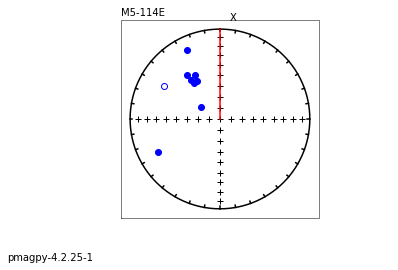

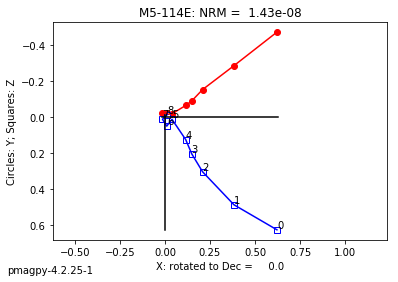

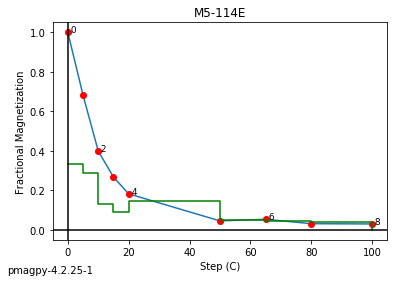

In [58]:
ipmag.zeq_magic(input_dir_path=dir_path, save_plots=False, n_plots=10)

### huji_sample_magic


[\[MagIC Database\]](https://earthref.org/MagIC)  [\[command line version\]](https://pmagpy.github.io/PmagPy-cli.html#huji_sample_magic.py)

To convert a Hebrew University Jersalem, Israel sample format to MagIC, use **convert.huji_sample()**.  

In [59]:
help(convert.huji_sample)

Help on function huji_sample in module pmagpy.convert_2_magic:

huji_sample(orient_file, meths='FS-FD:SO-POM:SO-SUN', location_name='unknown', samp_con='1', ignore_dip=True, data_model_num=3, samp_file='samples.txt', site_file='sites.txt', dir_path='.', input_dir_path='')
    Convert HUJI sample file to MagIC file(s)
    
    Parameters
    ----------
    orient_file : str
        input file name
    meths : str
       colon-delimited sampling methods, default FS-FD:SO-POM:SO-SUN
       for more options, see info below
    location : str
        location name, default "unknown"
    samp_con : str
        sample/site naming convention, default '1', see info below
    ignore_dip : bool
        set sample az/dip to 0, default True
    data_model_num : int
        MagIC data model 2 or 3, default 3
    samp_file : str
        sample file name to output (default : samples.txt)
    site_file : str
        site file name to output (default : site.txt)
    dir_path : str
        output directo

In [60]:
convert.huji_sample('magdelkrum_datafile.txt',
                   dir_path='data_files/convert_2_magic/huji_magic/')

-I- reading in: /Users/nebula/Python/PmagPy/data_files/convert_2_magic/huji_magic/magdelkrum_datafile.txt
57  records written to file  /Users/nebula/Python/PmagPy/data_files/convert_2_magic/huji_magic/samples.txt
57  records written to file  /Users/nebula/Python/PmagPy/data_files/convert_2_magic/huji_magic/sites.txt
Sample info saved in  /Users/nebula/Python/PmagPy/data_files/convert_2_magic/huji_magic/samples.txt
Site info saved in  /Users/nebula/Python/PmagPy/data_files/convert_2_magic/huji_magic/sites.txt


(True,
 '/Users/nebula/Python/PmagPy/data_files/convert_2_magic/huji_magic/samples.txt')

In [61]:
help(ipmag.combine_magic)

Help on function combine_magic in module pmagpy.ipmag:

combine_magic(filenames, outfile='measurements.txt', data_model=3, magic_table='measurements', dir_path='.', input_dir_path='')
    Takes a list of magic-formatted files, concatenates them, and creates a
    single file. Returns output filename if the operation was successful.
    
    Parameters
    -----------
    filenames : list of MagIC formatted files
    outfile : name of output file [e.g., measurements.txt]
    data_model : data model number (2.5 or 3), default 3
    magic_table : name of magic table, default 'measurements'
    dir_path : str
        output directory, default "."
    input_dir_path : str
        input file directory (if different from dir_path), default ""
    
    
    Returns
    ----------
    outfile name if success, False if failure



### iodp_dscr_lore

[\[MagIC Database\]](https://earthref.org/MagIC)  [\[command line version\]](https://pmagpy.github.io/PmagPy-cli.html#iodp_dscr_magic.py)

In [14]:
# first, generate specimens/samples/sites/locations files
convert.iodp_samples_csv('data_files/iodp_magic/U999A/samples_17_5_2019.csv')
# then, convert IODP discrete measurement files into measurements files
convert.iodp_dscr_lore("data_files/iodp_magic/U999A/SRM_discrete_data/srmdiscrete_17_5_2019.csv")
pmag.remove_files(["measurements.txt", "specimens.txt", "samples.txt", "sites.txt", "locations.txt"])

U999A
11  records written to file  /Users/nebula/Python/PmagPy/specimens.txt
11  records written to file  /Users/nebula/Python/PmagPy/samples.txt
11  records written to file  /Users/nebula/Python/PmagPy/sites.txt
1  records written to file  /Users/nebula/Python/PmagPy/locations.txt
 -W-  999-U999A-1H-2-W-140.0  not found in specimens table 
check your sample name or add to specimens table by hand

34  records written to file  /Users/nebula/Python/PmagPy/measurements.txt


### iodp_jr6_lore
[\[MagIC Database\]](https://earthref.org/MagIC)  [\[command line version\]](https://pmagpy.github.io/PmagPy-cli.html#iodp_jr6_magic.py)

In [3]:
# first, generate specimens/samples/sites/locations files
convert.iodp_samples_csv('data_files/iodp_magic/U999A/samples_17_5_2019.csv')
# then, convert IODP discrete measurement files into measurements files
convert.iodp_jr6_lore("data_files/iodp_magic/U999A/JR6_data/spinner_17_5_2019.csv")
pmag.remove_files(["measurements.txt", "specimens.txt", "samples.txt", "sites.txt", "locations.txt"])

U999A
11  records written to file  /Users/nebula/Python/PmagPy/specimens.txt
11  records written to file  /Users/nebula/Python/PmagPy/samples.txt
11  records written to file  /Users/nebula/Python/PmagPy/sites.txt
1  records written to file  /Users/nebula/Python/PmagPy/locations.txt
5  records written to file  /Users/nebula/Python/PmagPy/measurements.txt


### iodp_srm_lore
[\[MagIC Database\]](https://earthref.org/MagIC)  [\[command line version\]](https://pmagpy.github.io/PmagPy-cli.html#iodp_srm_magic.py)

In [15]:
convert.iodp_srm_lore("data_files/iodp_magic/U999A/SRM_archive_data/srmsection_17_5_2019.csv")

2804  records written to file  /Users/nebula/Python/PmagPy/srm_arch_specimens.txt
2804  records written to file  /Users/nebula/Python/PmagPy/srm_arch_samples.txt
2804  records written to file  /Users/nebula/Python/PmagPy/srm_arch_sites.txt
791  records written to file  /Users/nebula/Python/PmagPy/srm_arch_measurements.txt


(True, '/Users/nebula/Python/PmagPy/srm_arch_measurements.txt')

### jr6_jr6_magic

[\[MagIC Database\]](https://earthref.org/MagIC)  [\[command line version\]](https://pmagpy.github.io/PmagPy-cli.html#jr6_jr6_magic.py)

The AGICO JR6 spinner magnetometer has two output formats, the .jr6 and the .txt.  Here we illustrate the conversion of the .jr6 format.  There are data from two different studies in the example folder.  One (from Anita di Chiara) has the suffix '.JR6' and the other (from Roi Granot) are lower case (.jr6'). Each file has the data from a single specimen's experiment.  So, we can convert Anita's data to a series of MagIC formatted measurement files, combine them with [ipmag.combine_magic](#ipmag.combine_magic) and look at them with Demag GUI (on the command line) or [zeq_magic](#zeq_magic) within the notebook. 


In [62]:
help(convert.jr6_jr6)

Help on function jr6_jr6 in module pmagpy.convert_2_magic:

jr6_jr6(mag_file, dir_path='.', input_dir_path='', meas_file='measurements.txt', spec_file='specimens.txt', samp_file='samples.txt', site_file='sites.txt', loc_file='locations.txt', specnum=1, samp_con='1', location='unknown', lat='', lon='', noave=False, meth_code='LP-NO', volume=12, JR=False, user='')
    Convert JR6 .jr6 files to MagIC file(s)
    
    Parameters
    ----------
    mag_file : str
        input file name
    dir_path : str
        working directory, default "."
    input_dir_path : str
        input file directory IF different from dir_path, default ""
    meas_file : str
        output measurement file name, default "measurements.txt"
    spec_file : str
        output specimen file name, default "specimens.txt"
    samp_file: str
        output sample file name, default "samples.txt"
    site_file : str
        output site file name, default "sites.txt"
    loc_file : str
        output location file name,


Let's start with Anita's files

In [63]:
dir_path='data_files/convert_2_magic/jr6_magic/'
files=os.listdir(dir_path)
meas_files,spec_files,samp_files,site_files=[],[],[],[]
for file in files:
    if '.JR6' in file:
        print (file)
        stem=file.split('.')[0]
        meas_file=stem+'_measurements.txt' # make a unique measurements file
        spec_file=stem+'_specimens.txt'
        samp_file=stem+'_samples.txt'
        site_file=stem+'_sites.txt'
        convert.jr6_jr6(file,dir_path=dir_path,
                        meas_file=meas_file,spec_file=spec_file,samp_file=samp_file,
                        site_file=site_file,user='Anita')
        meas_files.append(dir_path+meas_file) # save the file name to a list
        spec_files.append(dir_path+spec_file)
        samp_files.append(dir_path+samp_file)
        site_files.append(dir_path+site_file)

# combine the files
ipmag.combine_magic(meas_files,dir_path+'measurements.txt')
ipmag.combine_magic(spec_files,dir_path+'specimens.txt',magic_table='specimens')
ipmag.combine_magic(samp_files,dir_path+'samples.txt',magic_table='samples')
ipmag.combine_magic(site_files,dir_path+'sites.txt',magic_table='sites')


SML02.JR6
-I- writing specimens records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/jr6_magic/SML02_specimens.txt
-I- 15 records written to specimens file
-I- writing samples records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/jr6_magic/SML02_samples.txt
-I- 2 records written to samples file
-I- writing sites records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/jr6_magic/SML02_sites.txt
-I- 1 records written to sites file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/jr6_magic/locations.txt
-I- 1 records written to locations file
-I- writing measurements records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/jr6_magic/SML02_measurements.txt
-I- 104 records written to measurements file
SML03.JR6
-I- writing specimens records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/jr6_magic/SML03_specimens.txt
-I- 15 records written to specimens file
-I- writing samples records to /Users/nebula/Python/PmagPy/d

'/Users/nebula/Python/PmagPy/data_files/convert_2_magic/jr6_magic/sites.txt'

(True, [])

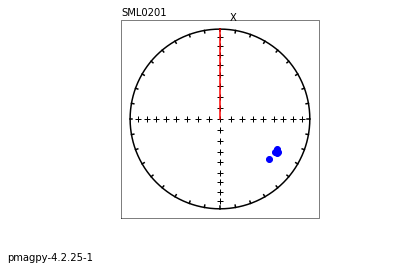

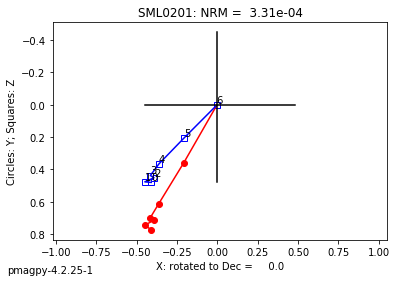

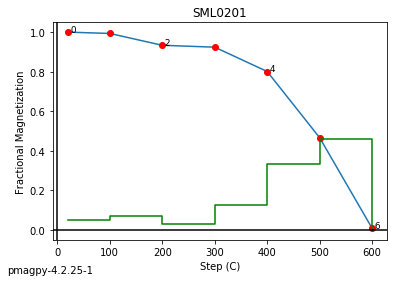

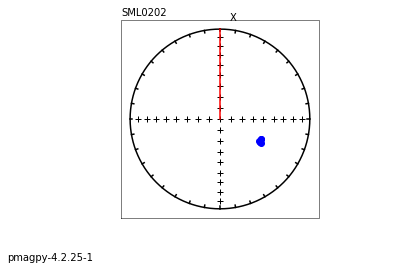

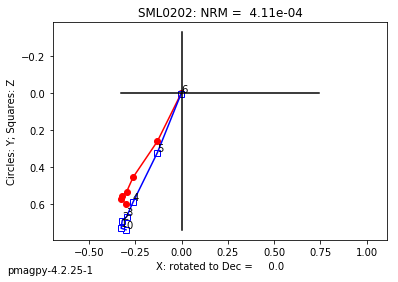

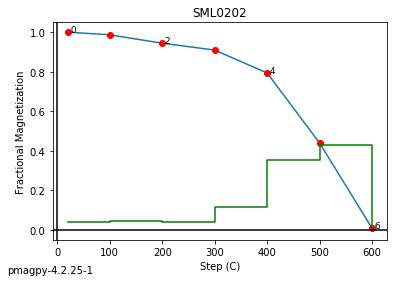

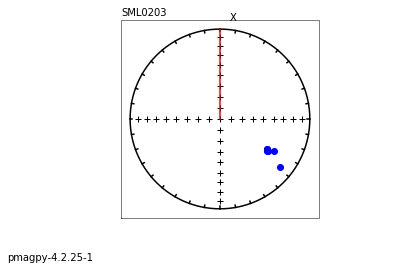

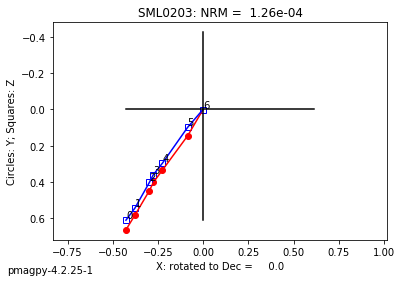

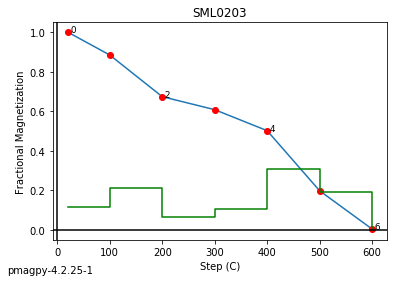

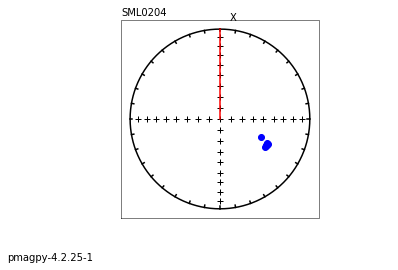

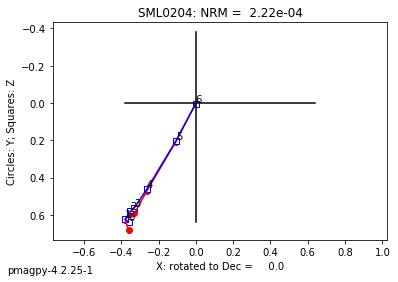

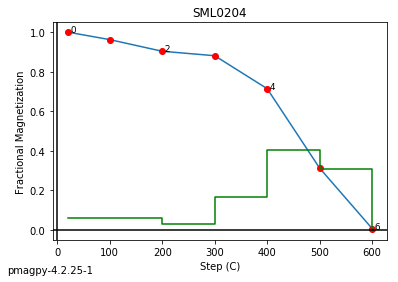

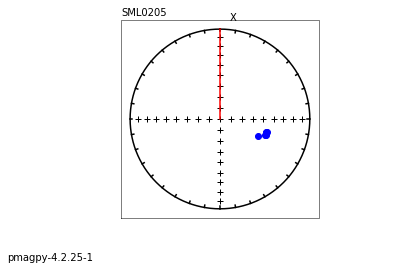

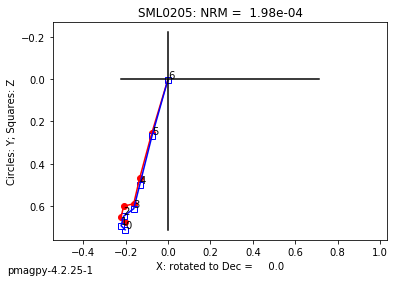

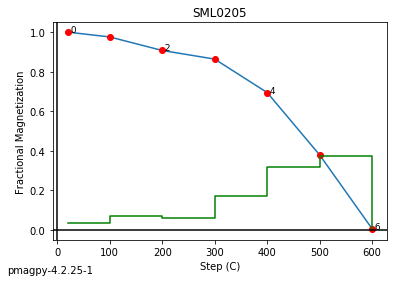

In [64]:
ipmag.zeq_magic(input_dir_path=dir_path, save_plots=False)

Now we can do Roi's files

In [65]:
dir_path='data_files/convert_2_magic/jr6_magic/'
files=os.listdir(dir_path)
meas_files,spec_files,samp_files,site_files=[],[],[],[]
for file in files:
    if file.endswith('.jr6'):
        stem=file.split('.')[0]
        meas_file=stem+'_measurements.txt' # make a unique measurements file
        spec_file=stem+'_specimens.txt'
        samp_file=stem+'_samples.txt'
        site_file=stem+'_sites.txt'
        convert.jr6_jr6(file,dir_path=dir_path,
                        meas_file=meas_file,spec_file=spec_file,samp_file=samp_file,
                        site_file=site_file,user='Roi')
        meas_files.append(dir_path+meas_file) # save the file name to a list
        spec_files.append(dir_path+spec_file)
        samp_files.append(dir_path+samp_file)
        site_files.append(dir_path+site_file)

# combine the files
ipmag.combine_magic(meas_files,dir_path+'measurements.txt')
ipmag.combine_magic(spec_files,dir_path+'specimens.txt',magic_table='specimens')
ipmag.combine_magic(samp_files,dir_path+'samples.txt',magic_table='samples')
ipmag.combine_magic(site_files,dir_path+'sites.txt',magic_table='sites')


-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/jr6_magic/TRM_specimens.txt
-I- 42 records written to specimens file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/jr6_magic/TRM_samples.txt
-I- 19 records written to samples file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/jr6_magic/TRM_sites.txt
-I- 10 records written to sites file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/jr6_magic/locations.txt
-I- 1 records written to locations file
-I- writing measurements records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/jr6_magic/TRM_measurements.txt
-I- 499 records written to measurements file
measurement type unknown -01A
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/jr6_magic/AF_specimens.txt
-I- 57 records written to specimens file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/jr6_magic/AF_samples.txt
-I- 17 records written to

'/Users/nebula/Python/PmagPy/data_files/convert_2_magic/jr6_magic/sites.txt'

(True, [])

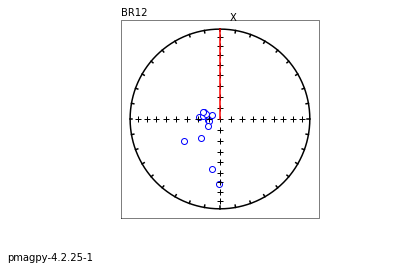

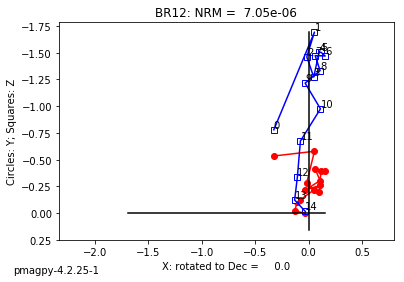

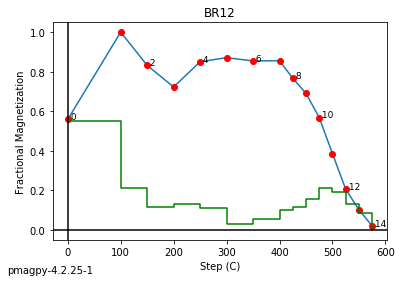

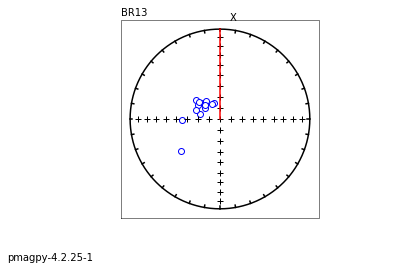

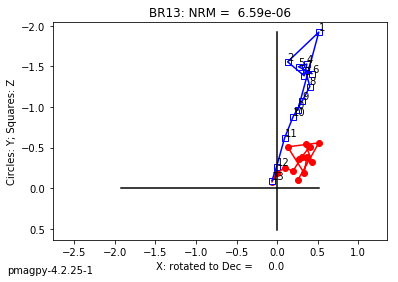

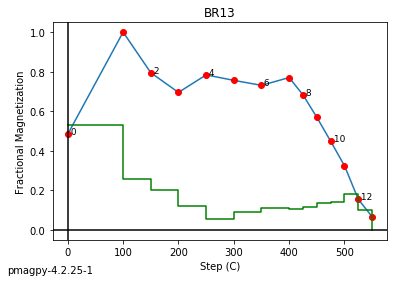

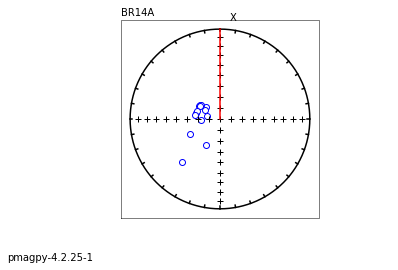

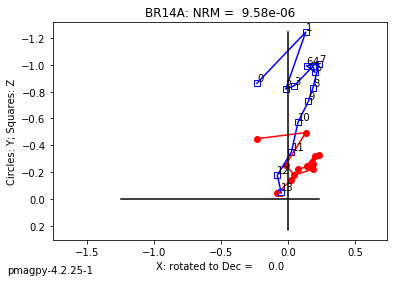

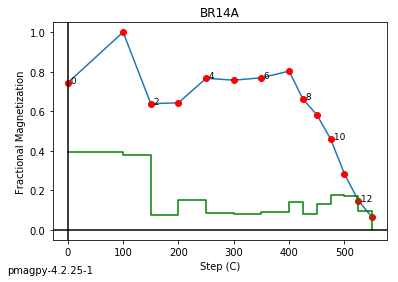

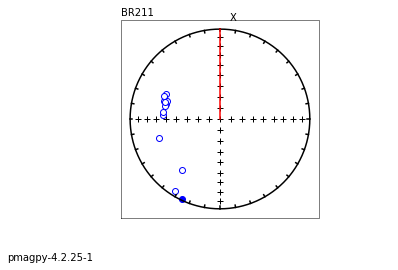

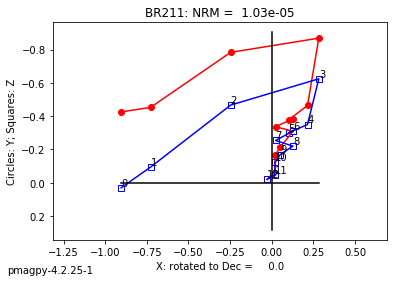

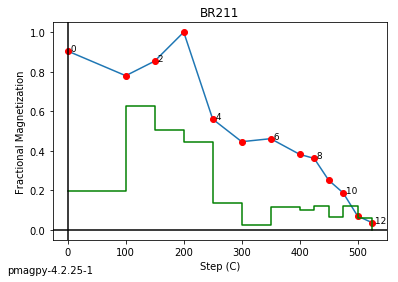

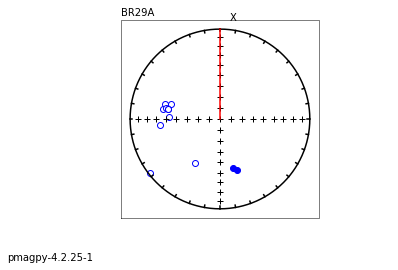

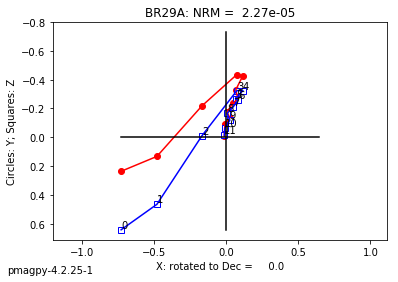

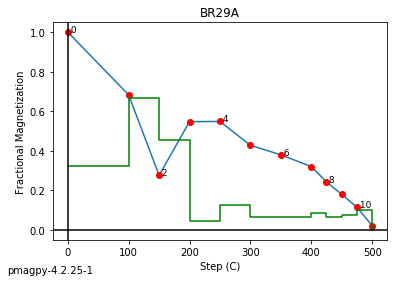

In [66]:
ipmag.zeq_magic(input_dir_path=dir_path, save_plots=False)

### jr6_txt_magic

[\[MagIC Database\]](https://earthref.org/MagIC)  [\[command line version\]](https://pmagpy.github.io/PmagPy-cli.html#jr6_txt_magic.py)

We can repeat the exercise for the JR6 .txt format using **convert.jr6_txt()**.  

In [67]:
help(convert.jr6_txt)

Help on function jr6_txt in module pmagpy.convert_2_magic:

jr6_txt(mag_file, dir_path='.', input_dir_path='', meas_file='measurements.txt', spec_file='specimens.txt', samp_file='samples.txt', site_file='sites.txt', loc_file='locations.txt', user='', specnum=1, samp_con='1', location='unknown', lat='', lon='', noave=False, volume=12, timezone='UTC', meth_code='LP-NO')
    Converts JR6 .txt format files to MagIC measurements format files.
    
    Parameters
    ----------
    mag_file : str
        input file name
    dir_path : str
        working directory, default "."
    input_dir_path : str
        input file directory IF different from dir_path, default ""
    meas_file : str
        output measurement file name, default "measurements.txt"
    spec_file : str
        output specimen file name, default "specimens.txt"
    samp_file: str
        output sample file name, default "samples.txt"
    site_file : str
        output site file name, default "sites.txt"
    loc_file : str
 

There are only data from Roi Granot in this format. The measurement values should be identical to the **convert.jr6_jr6()** function on .jr6 files with the same stem. Additional columns will be found when converting the .JR6 format as that format contains more information than the .txt files.

In [68]:
dir_path='data_files/convert_2_magic/jr6_magic/'
files=['AF.txt','TRM.txt','AP12.txt']
meas_files,spec_files,samp_files,site_files=[],[],[],[]
for file in files:
        print (file)
        stem=file.split('.')[0]
        meas_file=stem+'_measurements.txt' # make a unique measurements file
        spec_file=stem+'_specimens.txt'
        samp_file=stem+'_samples.txt'
        site_file=stem+'_sites.txt'
        convert.jr6_txt(file,dir_path=dir_path,
                        meas_file=meas_file,spec_file=spec_file,samp_file=samp_file,
                        site_file=site_file,user='Roi')
        meas_files.append(dir_path+meas_file) # save the file name to a list
        spec_files.append(dir_path+spec_file)
        samp_files.append(dir_path+samp_file)
        site_files.append(dir_path+site_file)

# combine the files
ipmag.combine_magic(meas_files,dir_path+'measurements.txt')
ipmag.combine_magic(spec_files,dir_path+'specimens.txt',magic_table='specimens')
ipmag.combine_magic(samp_files,dir_path+'samples.txt',magic_table='samples')
ipmag.combine_magic(site_files,dir_path+'sites.txt',magic_table='sites')

AF.txt
-I- Using less strict decoding for /Users/nebula/Python/PmagPy/data_files/convert_2_magic/jr6_magic/AF.txt, output may have formatting errors
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/jr6_magic/AF_specimens.txt
-I- 57 records written to specimens file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/jr6_magic/AF_samples.txt
-I- 17 records written to samples file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/jr6_magic/AF_sites.txt
-I- 10 records written to sites file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/jr6_magic/locations.txt
-I- 1 records written to locations file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/jr6_magic/AF_measurements.txt
-I- 655 records written to measurements file
TRM.txt
-I- Using less strict decoding for /Users/nebula/Python/PmagPy/data_files/convert_2_magic/jr6_magic/TRM.txt, output may have formatting errors
-I- overwritin

'/Users/nebula/Python/PmagPy/data_files/convert_2_magic/jr6_magic/sites.txt'

No plots could be created for specimen: AP12-01A
No plots could be created for specimen: AP12-02A
No plots could be created for specimen: AP12-03A


(True, [])

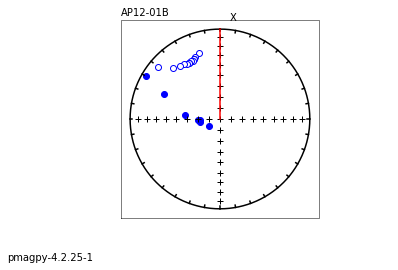

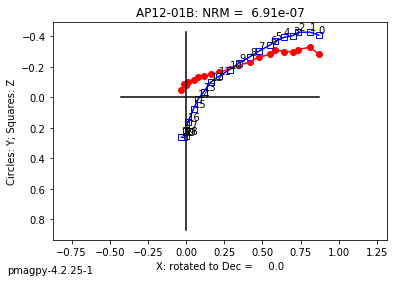

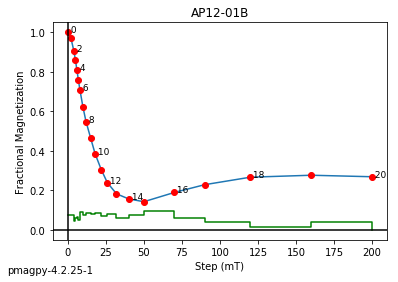

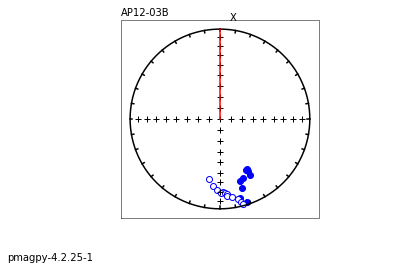

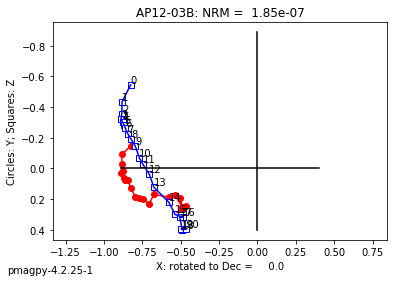

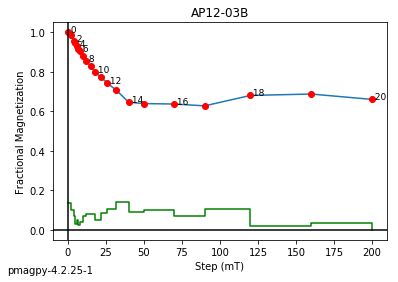

In [69]:
ipmag.zeq_magic(meas_file='AP12_measurements.txt',input_dir_path=dir_path, save_plots=False)

### k15_magic

[\[MagIC Database\]](https://earthref.org/MagIC)  [\[command line version\]](https://pmagpy.github.io/PmagPy-cli.html#k15_magic.py)

Someone took a set of samples from a dike margin in the Troodos Ophiolite and measured their anisotropy of magnetic susceptibility on an a Kappabridge KLY 2.0 instrument in the SIO laboratory.  An example of the  data file format is in k15_magic.  

The first line of each set of four has the specimen name, azimuth, plunge, and bedding strike and dip the next three lines are sets of five measurements in the 15 positions recommended by Jelinek (1977): 


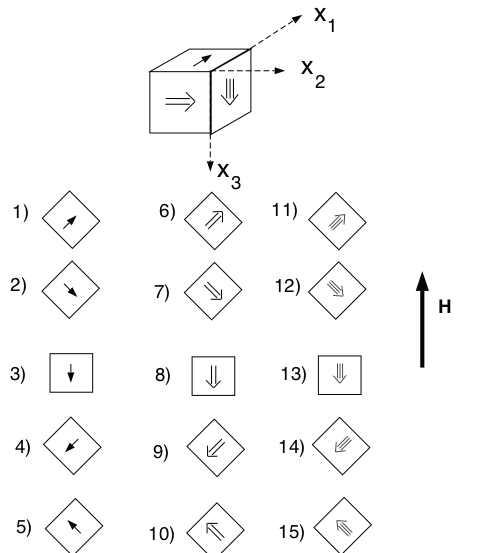

In [70]:
Image('data_files/Figures/meas15.png')

The 15 measurements for each specimen, along with orientation information and the specimen name were saved in the file data_files/k15_magic/k15_example.dat. 

To convert 15 measurement anisotropy of magnetic susceptibility file format to MagIC,   use **convert.k15()**. 

In [71]:
help(convert.k15)

Help on function k15 in module pmagpy.convert_2_magic:

k15(k15file, dir_path='.', input_dir_path='', meas_file='measurements.txt', aniso_outfile='specimens.txt', samp_file='samples.txt', result_file='rmag_anisotropy.txt', specnum=0, sample_naming_con='1', location='unknown', data_model_num=3)
    converts .k15 format data to MagIC  format.
    assumes Jelinek Kappabridge measurement scheme.
    
    Parameters
    ----------
    k15file : str
        input file name
    dir_path : str
        output file directory, default "."
    input_dir_path : str
        input file directory IF different from dir_path, default ""
    meas_file : str
        output measurement file name, default "measurements.txt"
    aniso_outfile : str
        output specimen file name, default "specimens.txt"
    samp_file: str
        output sample file name, default "samples.txt"
    aniso_results_file : str
        output result file name, default "rmag_results.txt", data model 2 only
    specnum : int
     

In [72]:
convert.k15('k15_example.dat',dir_path='data_files/convert_2_magic/k15_magic/',
            location='Troodos Ophiolite')

8  records written to file  /Users/nebula/Python/PmagPy/data_files/convert_2_magic/k15_magic/samples.txt
48  records written to file  /Users/nebula/Python/PmagPy/data_files/convert_2_magic/k15_magic/specimens.txt
120  records written to file  /Users/nebula/Python/PmagPy/data_files/convert_2_magic/k15_magic/measurements.txt
Data saved to: /Users/nebula/Python/PmagPy/data_files/convert_2_magic/k15_magic/measurements.txt, /Users/nebula/Python/PmagPy/data_files/convert_2_magic/k15_magic/specimens.txt, /Users/nebula/Python/PmagPy/data_files/convert_2_magic/k15_magic/samples.txt


(True,
 '/Users/nebula/Python/PmagPy/data_files/convert_2_magic/k15_magic/measurements.txt')

In [73]:
ipmag.aniso_magic_nb(infile='specimens.txt',dir_path='data_files/convert_2_magic/k15_magic/') 

1  saved in  Troodos Ophiolite_s_aniso-data.png
2  saved in  Troodos Ophiolite_s_aniso-conf.png


(True,
 ['Troodos Ophiolite_s_aniso-data.png', 'Troodos Ophiolite_s_aniso-conf.png'])

### kly4s_magic

[\[MagIC Database\]](https://earthref.org/MagIC)  [\[command line version\]](https://pmagpy.github.io/PmagPy-cli.html#kly4s_magic.py)

 The program AMSSpin available for downloading from http://earthref.org/ERDA/940/ generates data for the Kappabridge KLY4S spinning magnetic susceptibility instrument as described by Gee et al. (2008).



Output files are in the format of the file KLY4S_magic_example.dat (found in the measurement_import/kly4s_magic folder). 

The columns in the example file are:

Specimen S_1 S_2 S_3 S_4 S_5 S_6 χb(μSI) date time user




To convert the Agico Kappabridge KLY4S files generated by the SIO labview program (written by Jeff Gee), use **convert.kly4s()**. 
This function will create the files needed by the MagIC database and the data can be plotted using [aniso_magic](#aniso_magic).   If you were to import the sample files from the LIMS data base for these samples, you could plot them versus depth, or as equal area projections using **ani_depthplot** and **aniso_magic** respectively. 


In [74]:
help(convert.kly4s)

Help on function kly4s in module pmagpy.convert_2_magic:

kly4s(infile, specnum=0, locname='unknown', inst='SIO-KLY4S', samp_con='1', or_con='3', user='', measfile='measurements.txt', aniso_outfile='rmag_anisotropy.txt', samp_infile='', spec_infile='', spec_outfile='specimens.txt', azdip_infile='', dir_path='.', input_dir_path='', data_model_num=3, samp_outfile='samples.txt', site_outfile='sites.txt')
     converts files generated by SIO kly4S labview program to MagIC formated
    
     Parameters
     ----------
     infile :  str
         input file name
     specnum : int
         number of characters to designate a specimen, default 0
     locname : str
         location name, default "unknown"
     samp_con : str
         sample/site naming convention, default '1', see info below
     or_con : number
         orientation convention, default '3', see info below
     user : str
         user name, default ""
     measfile : str
         output measurement file name, default "measure

In [75]:
convert.kly4s('KLY4S_magic_example.dat',
              dir_path='data_files/convert_2_magic/kly4s_magic/')

anisotropy data added to specimen records
52  records written to file  /Users/nebula/Python/PmagPy/data_files/convert_2_magic/kly4s_magic/specimens.txt
specimen information written to new file: /Users/nebula/Python/PmagPy/data_files/convert_2_magic/kly4s_magic/specimens.txt
26  records written to file  /Users/nebula/Python/PmagPy/data_files/convert_2_magic/kly4s_magic/measurements.txt
measurement data saved in  /Users/nebula/Python/PmagPy/data_files/convert_2_magic/kly4s_magic/measurements.txt
26  records written to file  samples.txt
26  records written to file  sites.txt


(True,
 '/Users/nebula/Python/PmagPy/data_files/convert_2_magic/kly4s_magic/measurements.txt')

In [76]:
ipmag.aniso_magic_nb(infile='specimens.txt',dir_path='data_files/convert_2_magic/kly4s_magic/') 

1  saved in  unknown_s_aniso-data.png
2  saved in  unknown_s_aniso-conf.png


(True, ['unknown_s_aniso-data.png', 'unknown_s_aniso-conf.png'])

### ldeo_magic

[\[MagIC Database\]](https://earthref.org/MagIC)  [\[command line version\]](https://pmagpy.github.io/PmagPy-cli.html#ldeo_magic.py)

To convert Lamont-Doherty Earth Observatory data files to MagIC, use **convert.ldeo()**. 

NB:  this doesn't seem to work properly at all.  

In [77]:
help(convert.ldeo)

Help on function ldeo in module pmagpy.convert_2_magic:

ldeo(magfile, dir_path='.', input_dir_path='', meas_file='measurements.txt', spec_file='specimens.txt', samp_file='samples.txt', site_file='sites.txt', loc_file='locations.txt', specnum=0, samp_con='1', location='unknown', codelist='', coil='', arm_labfield=5e-05, trm_peakT=873.0, peakfield=0, labfield=0, phi=0, theta=0, mass_or_vol='v', noave=0)
    converts Lamont Doherty Earth Observatory measurement files to MagIC data base model 3.0
    
    Parameters
    _________
    magfile : input measurement file
    dir_path : output directory path, default "."
    input_dir_path : input file directory IF different from dir_path, default ""
    meas_file : output file measurement file name, default "measurements.txt"
    spec_file : output file specimen file name, default "specimens.txt"
    samp_file : output file sample file name, default "samples.txt"
    site_file : output file site file name, default "sites.txt"
    loc_file : ou

In [78]:
convert.ldeo('ldeo_magic_example.dat',codelist='AF',
             dir_path='data_files/convert_2_magic/ldeo_magic/')

-I- writing specimens records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/ldeo_magic/specimens.txt
-I- 35 records written to specimens file
-I- writing samples records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/ldeo_magic/samples.txt
-I- 35 records written to samples file
-I- writing sites records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/ldeo_magic/sites.txt
-I- 35 records written to sites file
-I- writing locations records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/ldeo_magic/locations.txt
-I- 1 records written to locations file
-I- writing measurements records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/ldeo_magic/measurements.txt
-I- 503 records written to measurements file


(True,
 '/Users/nebula/Python/PmagPy/data_files/convert_2_magic/ldeo_magic/measurements.txt')

(True, [])

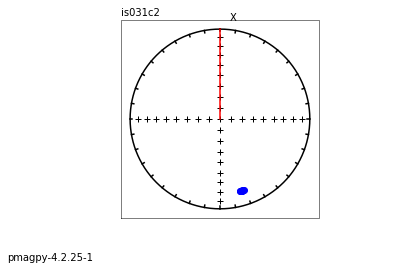

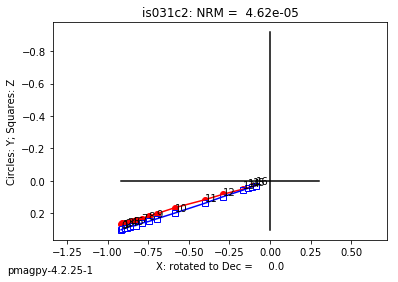

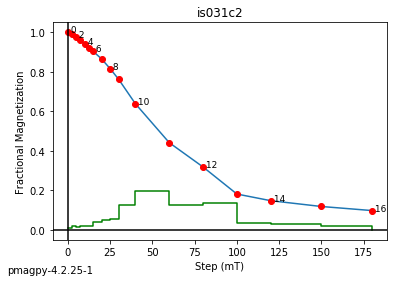

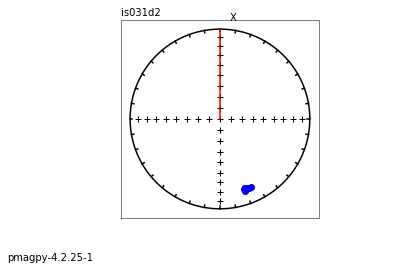

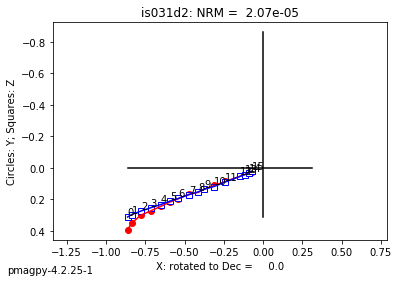

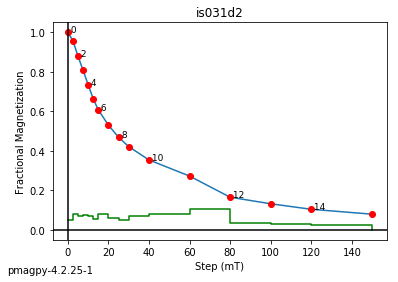

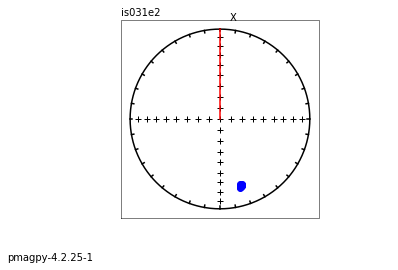

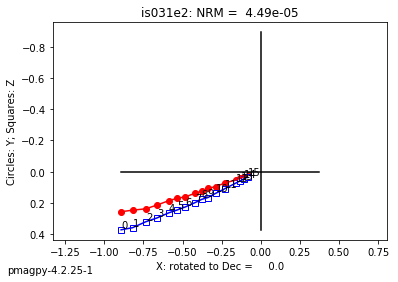

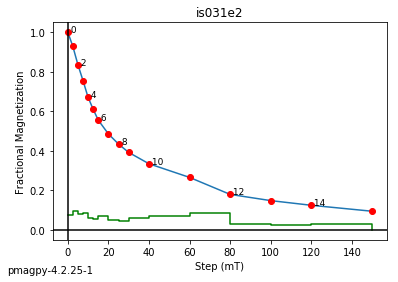

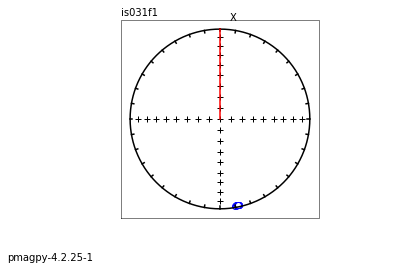

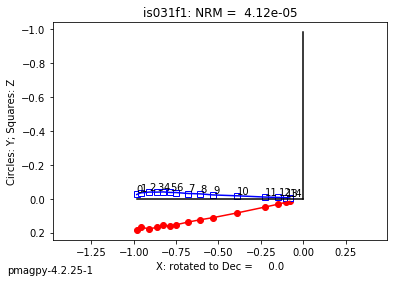

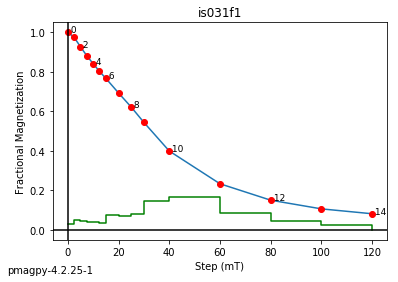

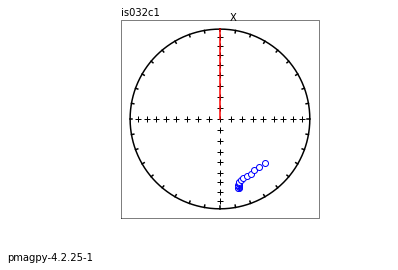

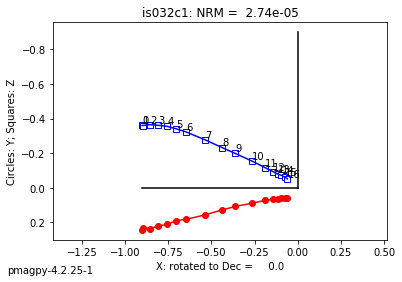

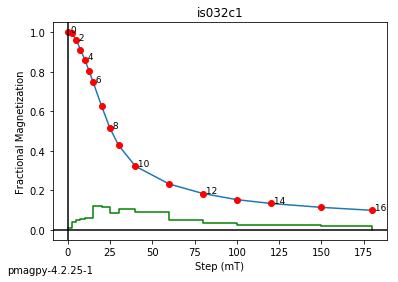

In [79]:
ipmag.zeq_magic(input_dir_path='data_files/convert_2_magic/ldeo_magic/', save_plots=False)

### livdb_magic 

[\[MagIC Database\]](https://earthref.org/MagIC)  [\[command line version\]](https://pmagpy.github.io/PmagPy-cli.html#livdb_magic.py)

To convert the Liverpool university database  format to MagIC use **convert.livdb()**.  

Here we have several experiment types as examples as examples.  



In [80]:
help(convert.livdb)

Help on function livdb in module pmagpy.convert_2_magic:

livdb(input_dir_path, output_dir_path='.', meas_out='measurements.txt', spec_out='specimens.txt', samp_out='samples.txt', site_out='sites.txt', loc_out='locations.txt', samp_name_con='sample=specimen', samp_num_chars=0, site_name_con='site=sample', site_num_chars=0, location_name='', data_model_num=3)
    Search input directory for Livdb .csv or .livdb files
    and convert them to MagIC format.
    Input directory should contain only input files for one location.
    
    Parameters
    ----------
    input_dir_path : str
        input directory with .csv or .livdb files to import
    output_dir_path : str
        directory to output files, default "."
    meas_out : str
        output measurement file name, default "measurements.txt"
    spec_out : str
        output specimen file name, default "specimens.txt"
    samp_out: str
        output sample file name, default "samples.txt"
    site_out : str
        output site file n

Here's an example for an IZZI style, thermal experiment:

In [81]:
convert.livdb('data_files/convert_2_magic/livdb_magic/TH_IZZI+/',
             output_dir_path='data_files/convert_2_magic/livdb_magic/TH_IZZI+',
             site_name_con=2,site_num_chars=3)

Open file:  /Users/nebula/Python/PmagPy/data_files/convert_2_magic/livdb_magic/TH_IZZI+/ATPI_Thellier.livdb
Found a repeating measurement at line 18, sample ATPIPV26-15A. taking the last one
Found a repeating measurement at line 19, sample ATPIPV31-7B . taking the last one
659  records written to file  /Users/nebula/Python/PmagPy/data_files/convert_2_magic/livdb_magic/TH_IZZI+/measurements.txt
27  records written to file  /Users/nebula/Python/PmagPy/data_files/convert_2_magic/livdb_magic/TH_IZZI+/specimens.txt
-I- Removing non-MagIC column names from measurements: site location sample 

-I- Removing non-MagIC column names from specimens: site location height 

-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/livdb_magic/TH_IZZI+/measurements.txt
-I- 659 records written to measurements file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/livdb_magic/TH_IZZI+/specimens.txt
-I- 27 records written to specimens file
-I- overwriting /Users/nebula/

(True,
 '/Users/nebula/Python/PmagPy/data_files/convert_2_magic/livdb_magic/TH_IZZI+/measurements.txt')

ATPIPV04-1A
ATPIPV04-6A
ATPIPV04-7N
ATPIPV14-1A
ATPIPV14-2A


(True, [])

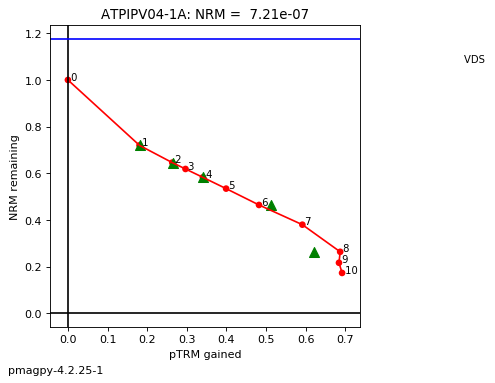

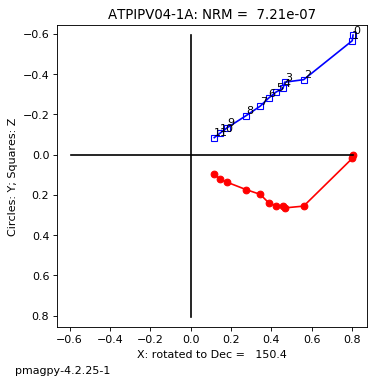

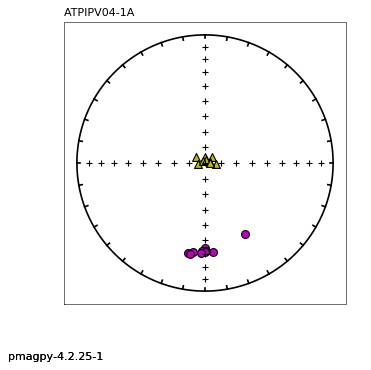

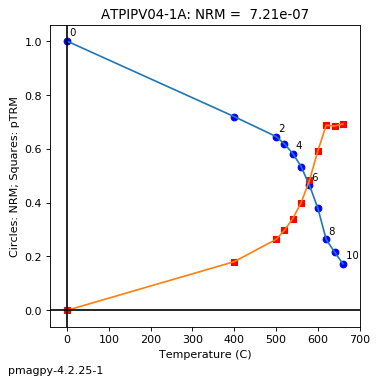

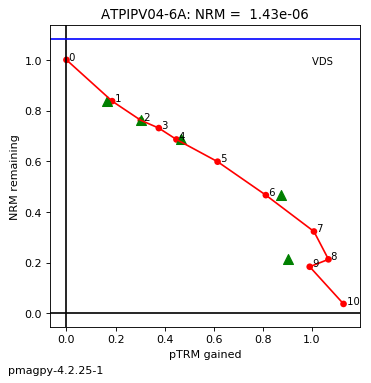

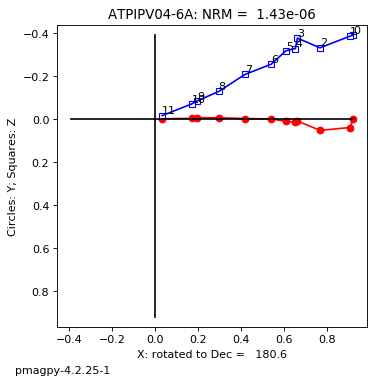

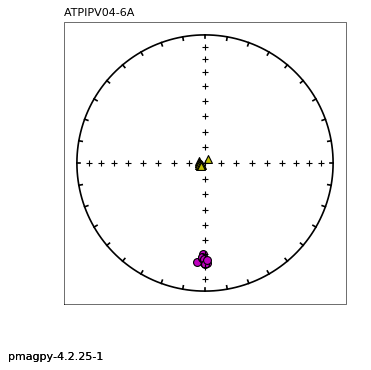

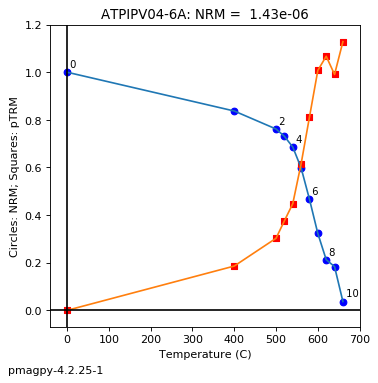

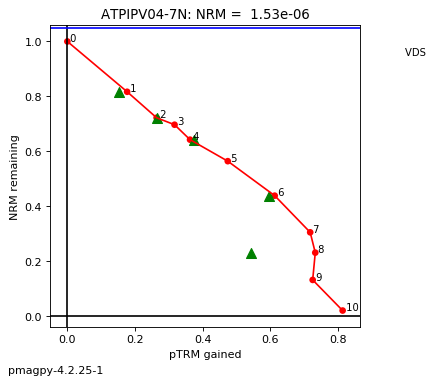

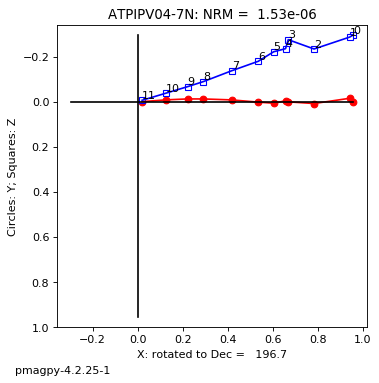

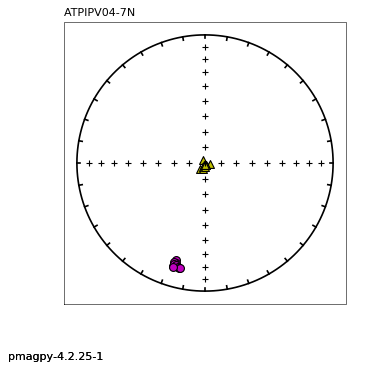

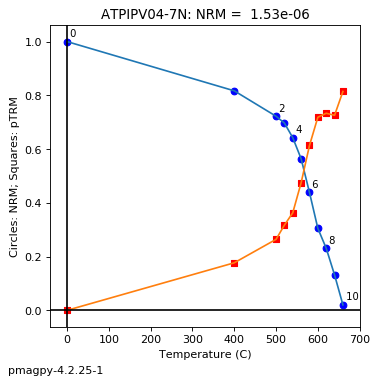

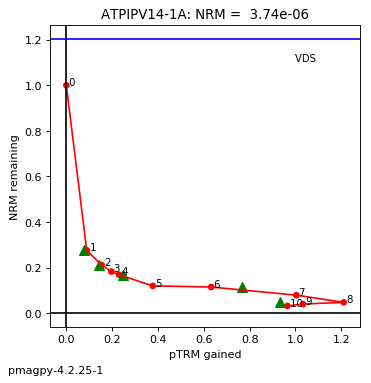

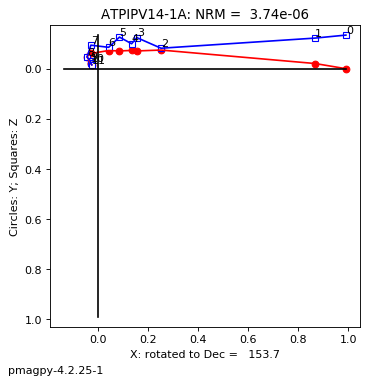

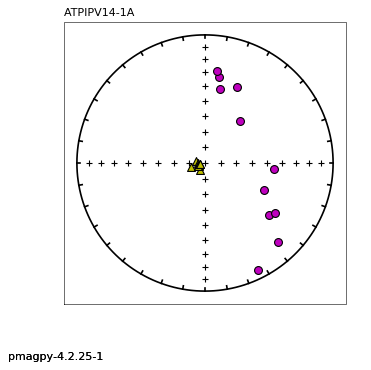

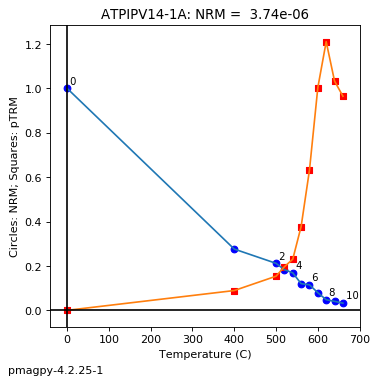

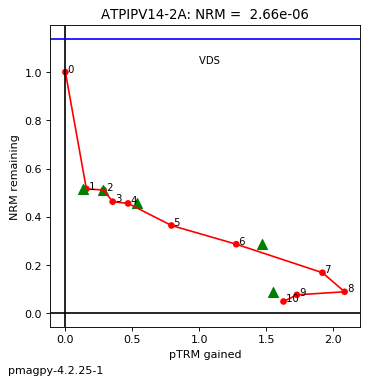

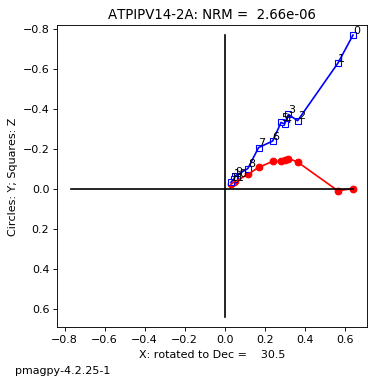

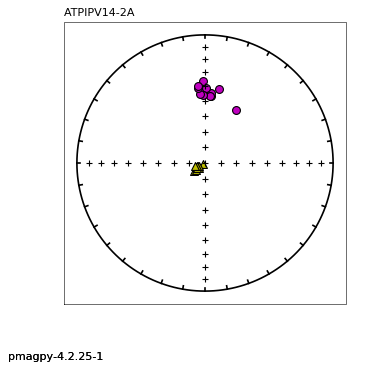

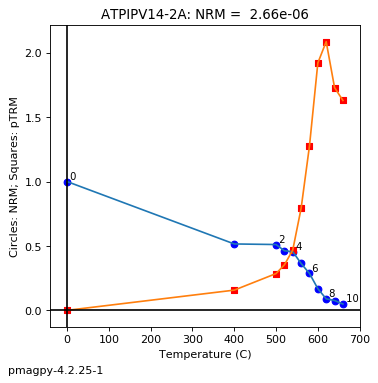

In [82]:
ipmag.thellier_magic(input_dir_path='data_files/convert_2_magic/livdb_magic/TH_IZZI+', 
                     save_plots=False, interactive=False, n_specs=5)

here's one for microwave "C+" experiment

In [83]:
convert.livdb('data_files/convert_2_magic/livdb_magic/MW_C+/',
             output_dir_path='data_files/convert_2_magic/livdb_magic/MW_C+',
             site_name_con=2,site_num_chars=3)

Open file:  /Users/nebula/Python/PmagPy/data_files/convert_2_magic/livdb_magic/MW_C+/CHEV.livdb
23  records written to file  /Users/nebula/Python/PmagPy/data_files/convert_2_magic/livdb_magic/MW_C+/measurements.txt
1  records written to file  /Users/nebula/Python/PmagPy/data_files/convert_2_magic/livdb_magic/MW_C+/specimens.txt
-I- Removing non-MagIC column names from measurements: site location sample 

-I- Removing non-MagIC column names from specimens: site location height 

-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/livdb_magic/MW_C+/measurements.txt
-I- 23 records written to measurements file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/livdb_magic/MW_C+/specimens.txt
-I- 1 records written to specimens file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/livdb_magic/MW_C+/samples.txt
-I- 1 records written to samples file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/livdb_magic/MW

(True,
 '/Users/nebula/Python/PmagPy/data_files/convert_2_magic/livdb_magic/MW_C+/measurements.txt')

An example for both microwave IZZI and C++:

In [84]:
convert.livdb('data_files/convert_2_magic/livdb_magic/MW_IZZI+andC++/',
             output_dir_path='data_files/convert_2_magic/livdb_magic/MW_IZZI+andC++',
             samp_name_con='2', samp_num_chars=1,site_name_con=2,site_num_chars=1)

Open file:  /Users/nebula/Python/PmagPy/data_files/convert_2_magic/livdb_magic/MW_IZZI+andC++/NVPA.livdb
-W- WARNING sample NVPADC18A2 treatment= 13. Step Type is O but the program assumes LT-M-I
-W- WARNING sample NVPADC18A2 treatment= 13. Step Type is O but the program assumes LT-M-I
-W- WARNING sample NVPADC18A2 treatment= 13. Step Type is Z but the program assumes LT-PMRM-MD
-W- livdb.py does not support this experiment type yet.
    Please report your issue on https://github.com/PmagPy/PmagPy/issues
-W- WARNING sample NVPATF16C2 treatment= 1. Step Type is Z but the program assumes LT-M-I
-W- WARNING sample NVPATF16C2 treatment= 3. Step Type is I but the program assumes LT-M-Z
-W- WARNING sample NVPATF16C2 treatment= 3. Step Type is Z but the program assumes LT-M-I
-W- WARNING sample NVPATF16C2 treatment= 2. Step Type is P but the program assumes LT-PMRM-MD
-W- WARNING sample NVPATF16C2 treatment= 4. Step Type is Z but the program assumes LT-M-I
-W- WARNING sample NVPATF16C2 treatm

(True,
 '/Users/nebula/Python/PmagPy/data_files/convert_2_magic/livdb_magic/MW_IZZI+andC++/measurements.txt')

An example for both microwave OT+:

In [85]:
convert.livdb('data_files/convert_2_magic/livdb_magic/MW_OT+/',
             output_dir_path='data_files/convert_2_magic/livdb_magic/MW_OT+',
             site_name_con=2,site_num_chars=3)

Open file:  /Users/nebula/Python/PmagPy/data_files/convert_2_magic/livdb_magic/MW_OT+/16-1.livdb
45  records written to file  /Users/nebula/Python/PmagPy/data_files/convert_2_magic/livdb_magic/MW_OT+/measurements.txt
1  records written to file  /Users/nebula/Python/PmagPy/data_files/convert_2_magic/livdb_magic/MW_OT+/specimens.txt
-I- Removing non-MagIC column names from measurements: site location sample 

-I- Removing non-MagIC column names from specimens: site location height 

-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/livdb_magic/MW_OT+/measurements.txt
-I- 45 records written to measurements file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/livdb_magic/MW_OT+/specimens.txt
-I- 1 records written to specimens file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/livdb_magic/MW_OT+/samples.txt
-I- 1 records written to samples file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/livdb_ma

(True,
 '/Users/nebula/Python/PmagPy/data_files/convert_2_magic/livdb_magic/MW_OT+/measurements.txt')

And an example for MW_P experiments.   

In [86]:
convert.livdb('data_files/convert_2_magic/livdb_magic/MW_P/',
             output_dir_path='data_files/convert_2_magic/livdb_magic/MW_P',
             site_name_con=2,site_num_chars=3)

Open file:  /Users/nebula/Python/PmagPy/data_files/convert_2_magic/livdb_magic/MW_P/perp.csv
73  records written to file  /Users/nebula/Python/PmagPy/data_files/convert_2_magic/livdb_magic/MW_P/measurements.txt
4  records written to file  /Users/nebula/Python/PmagPy/data_files/convert_2_magic/livdb_magic/MW_P/specimens.txt
-I- Removing non-MagIC column names from measurements: site location sample 

-I- Removing non-MagIC column names from specimens: site location height 

-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/livdb_magic/MW_P/measurements.txt
-I- 73 records written to measurements file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/livdb_magic/MW_P/specimens.txt
-I- 4 records written to specimens file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/livdb_magic/MW_P/samples.txt
-I- 4 records written to samples file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/livdb_magic/MW_P/sites

(True,
 '/Users/nebula/Python/PmagPy/data_files/convert_2_magic/livdb_magic/MW_P/measurements.txt')

Now you can look at these data (except for MW_P) with thellier_gui or [thellier_magic](#thellier_magic).

### mst_magic

[\[MagIC Database\]](https://earthref.org/MagIC)  [\[command line version\]](https://pmagpy.github.io/PmagPy-cli.html#mst_magic.py)

To convert a Curie Temperature experiment to MagIC, use **convert.mst()**.  The data file format should be a space delimited file with temperature and magnetization couplets.   

In [87]:
help(convert.mst)

Help on function mst in module pmagpy.convert_2_magic:

mst(infile, spec_name='unknown', dir_path='.', input_dir_path='', meas_file='measurements.txt', samp_infile='samples.txt', user='', specnum=0, samp_con='1', labfield=0.5, location='unknown', syn=False, data_model_num=3)
    Convert MsT data (T,M) to MagIC measurements format files
    
    Parameters
    ----------
    infile : str
        input file name
    specimen : str
        specimen name, default "unknown"
    dir_path : str
        working directory, default "."
    input_dir_path : str
        input file directory IF different from dir_path, default ""
    meas_file : str
        output measurement file name, default "measurements.txt"
    samp_infile : str
        existing sample infile (not required), default "samples.txt"
    user : str
        user name, default ""
    specnum : int
        number of characters to designate a specimen, default 0
    samp_con : str
        sample/site naming convention, default '1', s

In [88]:
convert.mst('curie_example.dat',samp_con="5",
           dir_path='data_files/convert_2_magic/mst_magic/')

560  records written to file  /Users/nebula/Python/PmagPy/data_files/convert_2_magic/mst_magic/measurements.txt
results put in  /Users/nebula/Python/PmagPy/data_files/convert_2_magic/mst_magic/measurements.txt
-I- writing specimens records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/mst_magic/specimens.txt
-I- 1 records written to specimens file
-I- writing samples records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/mst_magic/samples.txt
-I- 1 records written to samples file
-I- writing sites records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/mst_magic/sites.txt
-I- 1 records written to sites file
-I- writing locations records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/mst_magic/locations.txt
-I- 1 records written to locations file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/mst_magic/samples.txt
-I- 1 records written to samples file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magi

(True,
 '/Users/nebula/Python/PmagPy/data_files/convert_2_magic/mst_magic/measurements.txt')

We can now use [curie](#curie) to plot the data. 

second derivative maximum is at T=205


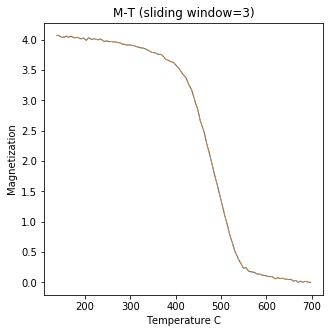

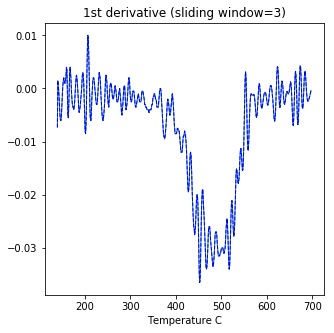

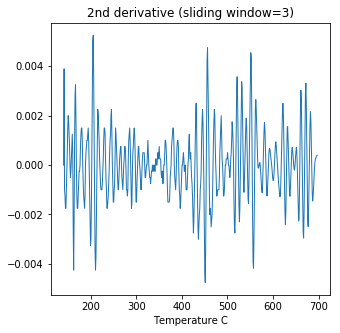

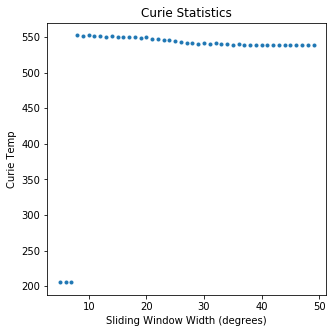

In [89]:
ipmag.curie(path_to_file='data_files/convert_2_magic/mst_magic/',file_name='measurements.txt',magic=True)

### pmd_magic 

[\[MagIC Database\]](https://earthref.org/MagIC)  [\[command line version\]](https://pmagpy.github.io/PmagPy-cli.html#pmd_magic.py)

 This format is the one used to import .PMD formatted magnetometer files (used for example in the PaleoMac software of Cogné, 2003) into the MagIC format. (See http://www.ipgp.fr/~cogne/pub/paleomac/PMhome.html for the PaleoMac home page. The version of these files that **pmd_magic** expects (UCSC version) contains demagnetization data for a single specimen and has a format as in the example file in ../measurement_import/pmd_magic/PMD/ss0207a.pmd


The first line is a comment line. The second line has the specimen name, the core azimuth (a=) and plunge (b=) which are assumed to be the lab arrow azimuth and plunge (Orientation scheme #4)D. The third line is a header explaining the columns in the file.

Use **convert.pmd()**  to convert the file ss0101a.pmd in the directory ’PMD’ in the ’pmd_magic’ folder of the measurement_import directory in the example data_files directory. These were taken at a location named ’Summit Springs’ and have a naming convention of the type XXXX[YYY], where YYY is sample designation with Z characters from site XXX, or naming convention # 4-2. A single character distinguishes the specimen from the sample (specnum=1). All samples were oriented with a magnetic compass. 

In [90]:
help(convert.pmd)

Help on function pmd in module pmagpy.convert_2_magic:

pmd(mag_file, dir_path='.', input_dir_path='', meas_file='measurements.txt', spec_file='specimens.txt', samp_file='samples.txt', site_file='sites.txt', loc_file='locations.txt', lat='', lon='', specnum=0, samp_con='1', location='unknown', noave=0, meth_code='LP-NO')
    converts PMD (Enkin)  format files to MagIC format files
    
    Parameters
    ----------
    mag_file : str
        input file name, required
    dir_path : str
        working directory, default "."
    input_dir_path : str
        input file directory IF different from dir_path, default ""
    spec_file : str
        output specimen file name, default "specimens.txt"
    samp_file: str
        output sample file name, default "samples.txt"
    site_file : str
        output site file name, default "sites.txt"
    loc_file : str
        output location file name, default "locations.txt"
    lat : float or str
        latitude, default ""
    lon : float or str


In [91]:
convert.pmd('ss0207a.pmd',dir_path='data_files/convert_2_magic/pmd_magic/PMD/',
           samp_con='4-2',location='Summit Springs',specnum=1)

-I- writing specimens records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/pmd_magic/PMD/specimens.txt
-I- 1 records written to specimens file
-I- writing samples records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/pmd_magic/PMD/samples.txt
-I- 1 records written to samples file
-I- writing sites records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/pmd_magic/PMD/sites.txt
-I- 1 records written to sites file
-I- writing locations records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/pmd_magic/PMD/locations.txt
-I- 1 records written to locations file
-I- writing measurements records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/pmd_magic/PMD/measurements.txt
-I- 8 records written to measurements file


(True,
 '/Users/nebula/Python/PmagPy/data_files/convert_2_magic/pmd_magic/PMD/measurements.txt')

### sio_magic

[\[MagIC Database\]](https://earthref.org/MagIC)  [\[command line version\]](https://pmagpy.github.io/PmagPy-cli.html#sio_magic.py)

This program allows conversion of the SIO format magnetometer files to the MagIC common measurements format. The columns in the example data file are: 

Specimen treatment intensity declination inclination optional_string 

The treatment field is the temperature (in centigrade), the AF field (in mT), the impulse field strength, etc. For special experiments like IRM acquisition, the coil number of the popular ASC impulse magnetizer can be specified if the treatment steps are in volts. The position for anisotropy experiments or whether the treatment is “in-field” or in zero field also require special formatting. The units of the intensity field are in cgs and the directions are relative to the ‘lab arrow’ on the specimen. Here are some examples of commonly used specimens and conversions from field arrow to lab arrow. 

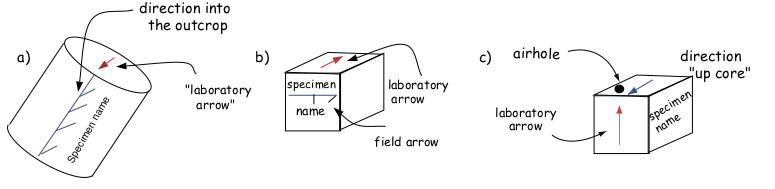

In [92]:
Image('data_files/Figures/samples.png')

As an example, we use data from Sbarbori et al. (2009) done on a set of samples from the location “Socorro”, including AF, thermal, and thellier experimental data. These were saved in sio_af_example.dat, sio_thermal_example.dat, and sio_thellier_example.dat respectively. The lab field for the thellier experiment was 25 μT and was applied along the specimen’s Z axis (phi=0,theta=90).] 

We can convert the example files into measurement formatted files with names like af_measurements.txt, etc. using the function **convert.sio()**.   Then combine them together following the instructions for  [combine_magic](#combine_magic).   

In [93]:
help(convert.sio)

Help on function sio in module pmagpy.convert_2_magic:

sio(mag_file, dir_path='.', input_dir_path='', meas_file='measurements.txt', spec_file='specimens.txt', samp_file='samples.txt', site_file='sites.txt', loc_file='locations.txt', samp_infile='', institution='', syn=False, syntype='', instrument='', labfield=0, phi=0, theta=0, peakfield=0, specnum=0, samp_con='1', location='unknown', lat='', lon='', noave=False, codelist='', cooling_rates='', coil='', timezone='UTC', user='')
    converts Scripps Institution of Oceanography measurement files to MagIC data base model 3.0
    
    Parameters
    _________
    magfile : input measurement file
    dir_path : output directory path, default "."
    input_dir_path : input file directory IF different from dir_path, default ""
    meas_file : output file measurement file name, default "measurements.txt"
    spec_file : output file specimen file name, default "specimens.txt"
    samp_file : output file sample file name, default "samples.tt"
 

In [94]:
convert.sio('sio_af_example.dat',dir_path='data_files/convert_2_magic/sio_magic/',
           specnum=1,location='Isla Soccoro',codelist='AF',samp_con='1',
           meas_file='af_measurements.txt',spec_file='af_specimens.txt',
           samp_file='af_samples.txt',site_file='af_sites.txt')

-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/sio_magic/af_specimens.txt
-I- 1 records written to specimens file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/sio_magic/af_samples.txt
-I- 1 records written to samples file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/sio_magic/af_sites.txt
-I- 1 records written to sites file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/sio_magic/locations.txt
-I- 1 records written to locations file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/sio_magic/af_measurements.txt
-I- 14 records written to measurements file


(True,
 '/Users/nebula/Python/PmagPy/data_files/convert_2_magic/sio_magic/af_measurements.txt')

In [95]:
convert.sio('sio_thermal_example.dat',dir_path='data_files/convert_2_magic/sio_magic/',
            specnum=1,location='Isla Soccoro',codelist='T',
            meas_file='thermal_measurements.txt',spec_file='thermal_specimens.txt',
            samp_file='thermal_samples.txt',site_file='thermal_sites.txt')

-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/sio_magic/thermal_specimens.txt
-I- 1 records written to specimens file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/sio_magic/thermal_samples.txt
-I- 1 records written to samples file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/sio_magic/thermal_sites.txt
-I- 1 records written to sites file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/sio_magic/locations.txt
-I- 1 records written to locations file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/sio_magic/thermal_measurements.txt
-I- 22 records written to measurements file


(True,
 '/Users/nebula/Python/PmagPy/data_files/convert_2_magic/sio_magic/thermal_measurements.txt')

And combine them together... 

In [96]:
# combine the measurements files
measfiles=['data_files/convert_2_magic/sio_magic/af_measurements.txt',
           'data_files/convert_2_magic/sio_magic/thermal_measurements.txt']
ipmag.combine_magic(measfiles,'data_files/convert_2_magic/sio_magic/measurements.txt')

specfiles=['data_files/convert_2_magic/sio_magic/af_specimens.txt',
           'data_files/convert_2_magic/sio_magic/thermal_specimens.txt']
ipmag.combine_magic(specfiles,'data_files/convert_2_magic/sio_magic/specimens.txt', magic_table='specimens')

sitefiles=['data_files/convert_2_magic/sio_magic/af_sites.txt',
           'data_files/convert_2_magic/sio_magic/thermal_sites.txt']
ipmag.combine_magic(sitefiles,'data_files/convert_2_magic/sio_magic/sites.txt',magic_table='sites')


-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/sio_magic/measurements.txt
-I- 36 records written to measurements file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/sio_magic/specimens.txt
-I- 2 records written to specimens file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/sio_magic/sites.txt
-I- 1 records written to sites file


'/Users/nebula/Python/PmagPy/data_files/convert_2_magic/sio_magic/sites.txt'

### sufar4_magic

[\[MagIC Database\]](https://earthref.org/MagIC)  [\[command line version\]](https://pmagpy.github.io/PmagPy-cli.html#sufar4_asc_magic.py)

The AGICO program SUFAR creates ascii txt files as output.  **convert.sufar4()** will convert these to the MagIC format.

In [97]:
help(convert.sufar4)

Help on function sufar4 in module pmagpy.convert_2_magic:

sufar4(ascfile, meas_output='measurements.txt', aniso_output='rmag_anisotropy.txt', spec_infile=None, spec_outfile='specimens.txt', samp_outfile='samples.txt', site_outfile='sites.txt', specnum=0, sample_naming_con='1', user='', locname='unknown', instrument='', static_15_position_mode=False, dir_path='.', input_dir_path='', data_model_num=3)
    Converts ascii files generated by SUFAR ver.4.0 to MagIC files
    
    Parameters
    ----------
    ascfile : str
        input ASC file, required
    meas_output : str
        measurement output filename, default "measurements.txt"
    aniso_output : str
        anisotropy output filename, MagIC 2 only, "rmag_anisotropy.txt"
    spec_infile : str
        specimen infile, default None
    spec_outfile : str
        specimen outfile, default "specimens.txt"
    samp_outfile : str
        sample outfile, default "samples.txt"
    site_outfile : str
        site outfile, default "sites.

In [98]:
convert.sufar4('sufar4-asc_magic_example.txt',dir_path='data_files/convert_2_magic/sufar_asc_magic/',
              sample_naming_con='5',locname='U1356A')

290  records written to file  /Users/nebula/Python/PmagPy/data_files/convert_2_magic/sufar_asc_magic/measurements.txt
bulk measurements put in  /Users/nebula/Python/PmagPy/data_files/convert_2_magic/sufar_asc_magic/measurements.txt
728  records written to file  /Users/nebula/Python/PmagPy/data_files/convert_2_magic/sufar_asc_magic/specimens.txt
specimen/anisotropy info put in  /Users/nebula/Python/PmagPy/data_files/convert_2_magic/sufar_asc_magic/specimens.txt
148  records written to file  /Users/nebula/Python/PmagPy/data_files/convert_2_magic/sufar_asc_magic/samples.txt
sample info put in  /Users/nebula/Python/PmagPy/data_files/convert_2_magic/sufar_asc_magic/samples.txt
148  records written to file  /Users/nebula/Python/PmagPy/data_files/convert_2_magic/sufar_asc_magic/sites.txt
site info put in  /Users/nebula/Python/PmagPy/data_files/convert_2_magic/sufar_asc_magic/sites.txt


(True,
 '/Users/nebula/Python/PmagPy/data_files/convert_2_magic/sufar_asc_magic/measurements.txt')

Now we can test it out with, for example, [ipmag.aniso_magic_nb()](#aniso_magic)

In [99]:
ipmag.aniso_magic_nb(infile='data_files/convert_2_magic/sufar_asc_magic/specimens.txt')

1  saved in  U1356A_s_aniso-data.png
2  saved in  U1356A_s_aniso-conf.png


(True, ['U1356A_s_aniso-data.png', 'U1356A_s_aniso-conf.png'])

### tdt_magic

[\[MagIC Database\]](https://earthref.org/MagIC)  [\[command line version\]](https://pmagpy.github.io/PmagPy-cli.html#tdt_magic.py)

Convertions of the Thellier Tool format of Leonhardt et al., 2004 can be done with **convert.tdt()**.  THERE IS A PROBLEM WITH THE XXX.4 TREATMENT STEP CONVERSION.  

In [100]:
help(convert.tdt)

Help on function tdt in module pmagpy.convert_2_magic:

tdt(input_dir_path, experiment_name='Thellier', meas_file_name='measurements.txt', spec_file_name='specimens.txt', samp_file_name='samples.txt', site_file_name='sites.txt', loc_file_name='locations.txt', user='', location='', lab_dec=0, lab_inc=90, moment_units='mA/m', samp_name_con='sample=specimen', samp_name_chars=0, site_name_con='site=sample', site_name_chars=0, volume=12.0, output_dir_path='')
    converts TDT formatted files to measurements format files
    
    Parameters
    ----------
    input_dir_path : str
        directory with one or more .tdt files
    experiment: str
        one of: ["Thellier", "ATRM 6 pos", "NLT"], default "Thellier"
    meas_file_name : str
        default "measurements.txt"
    spec_file_name : str
        default "specimens.txt"
    samp_file_name : str
        default "samples.txt"
    site_file_name : str
        default "sites.txt"
    loc_file_name : str
        default "locations.txt"
  

In [101]:
convert.tdt('data_files/convert_2_magic/tdt_magic/')

Open file:  data_files/convert_2_magic/tdt_magic/Krasa_MGH1.tdt
Open file:  data_files/convert_2_magic/tdt_magic/Krasa_MGH1_noAC.tdt
-I- writing specimens records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/tdt_magic/specimens.txt
-I- 1 records written to specimens file
-I- writing samples records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/tdt_magic/samples.txt
-I- 1 records written to samples file
-I- writing sites records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/tdt_magic/sites.txt
-I- 1 records written to sites file
-I- writing locations records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/tdt_magic/locations.txt
-I- 1 records written to locations file
-I- writing measurements records to /Users/nebula/Python/PmagPy/data_files/convert_2_magic/tdt_magic/measurements.txt
-I- 40 records written to measurements file


(True,
 '/Users/nebula/Python/PmagPy/data_files/convert_2_magic/tdt_magic/measurements.txt')

### utrecht_magic

[\[MagIC Database\]](https://earthref.org/MagIC)  [\[command line version\]](https://pmagpy.github.io/PmagPy-cli.html#utrecht_magic.py)


In [102]:
help(convert.utrecht)

Help on function utrecht in module pmagpy.convert_2_magic:

utrecht(mag_file, dir_path='.', input_dir_path='', meas_file='measurements.txt', spec_file='specimens.txt', samp_file='samples.txt', site_file='sites.txt', loc_file='locations.txt', location='unknown', lat='', lon='', dmy_flag=False, noave=False, meas_n_orient=8, meth_code='LP-NO', specnum=1, samp_con='2', labfield=0, phi=0, theta=0)
    Converts Utrecht magnetometer data files to MagIC files
    
    Parameters
    ----------
    mag_file : str
        input file name
    dir_path : str
        working directory, default "."
    input_dir_path : str
        input file directory IF different from dir_path, default ""
    spec_file : str
        output specimen file name, default "specimens.txt"
    samp_file: str
        output sample file name, default "samples.txt"
    site_file : str
        output site file name, default "sites.txt"
    loc_file : str
        output location file name, default "locations.txt"
    append : 

In [103]:
convert.utrecht('Utrecht_Example.af',dir_path='data_files/convert_2_magic/utrecht_magic',
               specnum=0,samp_con='3')

-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/utrecht_magic/specimens.txt
-I- 25 records written to specimens file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/utrecht_magic/samples.txt
-I- 25 records written to samples file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/utrecht_magic/sites.txt
-I- 1 records written to sites file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/utrecht_magic/locations.txt
-I- 1 records written to locations file
-I- overwriting /Users/nebula/Python/PmagPy/data_files/convert_2_magic/utrecht_magic/measurements.txt
-I- 350 records written to measurements file


(True,
 '/Users/nebula/Python/PmagPy/data_files/convert_2_magic/utrecht_magic/measurements.txt')

### orientation_magic

[\[Preparing for MagIC\]](https://earthref.org/PmagPy/cookbook/#QQ2-1-25) [\[command line version\]](https://pmagpy.github.io/PmagPy-cli.html#orientation_magic.py)

**orientation_magic** is meant to import the field book data as entered into the format like in  orientation_example.txt into the MagIC format samples, sites and location tables.  
Click [here](https://earthref.org/PmagPy/cookbook/#field_info)  for details about the orient.txt file format. The example file used here has field information for a few sites. The samples were oriented with a Pomeroy orientation device (the default) and it is desirable to calculate the magnetic declination from the IGRF at the time of sampling (also the default). Sample names follow the rule that the sample is designated by a letter at the end of the site name (convention \#1 - which is also the default). We can do this from within a notebook by calling  **ipmag.orientation_magic()**.


In [104]:
help(ipmag.orientation_magic)

Help on function orientation_magic in module pmagpy.ipmag:

orientation_magic(or_con=1, dec_correction_con=1, dec_correction=0, bed_correction=True, samp_con='1', hours_from_gmt=0, method_codes='', average_bedding=False, orient_file='orient.txt', samp_file='samples.txt', site_file='sites.txt', output_dir_path='.', input_dir_path='', append=False, data_model=3)
        use this function to convert tab delimited field notebook information to MagIC formatted tables (er_samples and er_sites)
    
        INPUT FORMAT
            Input files must be tab delimited and have in the first line:
    tab  location_name
            Note: The "location_name" will facilitate searching in the MagIC database. Data from different
                "locations" should be put in separate files.  The definition of a "location" is rather loose.
                 Also this is the word 'tab' not a tab, which will be indicated by '        '.
            The second line has the names of the columns (tab delimited)

 We need to know which orientation convention was used to take the samples (it was with a Pomeroy, so, the default).  We want to use the igrf calculated magnetic declination at each site (so dec_correction_con=1, the default).  These samples were collected in Antarctica with a local time of GMT+13, so we need to subtract 13 hours so hours_from_gmt should be 13.  we are using data model 3.0 for this notebook, so data_model=3.  Also, input_dir_path and output_dir_path are both ../orientation_magic.  

In [105]:
ipmag.orientation_magic(input_dir_path='data_files/orientation_magic',orient_file='orient_example.txt',
                        hours_from_gmt=13,data_model=3,output_dir_path='data_files/orientation_magic')

setting location name to ""
setting location name to ""
saving data...
24  records written to file  /Users/nebula/Python/PmagPy/data_files/orientation_magic/samples.txt
2  records written to file  /Users/nebula/Python/PmagPy/data_files/orientation_magic/sites.txt
Data saved in  /Users/nebula/Python/PmagPy/data_files/orientation_magic/samples.txt  and  /Users/nebula/Python/PmagPy/data_files/orientation_magic/sites.txt


(True, None)

### azdip_magic

[\[MagIC Database\]](https://earthref.org/MagIC)  [\[command line version\]](https://pmagpy.github.io/PmagPy-cli.html#azdip_magic.py)

Many paleomagnetists save orientation information in files in this format: Sample Azimuth Plunge Strike Dip (AZDIP format), where the Azimuth and Plunge are the declination and inclination of the drill direction and the strike and dip are the attitude of the sampled unit (with dip to the right of strike). Of course there are many ways to think about sample orientation and the MagIC database convention is to store the direction of the X coordinate of the specimen measurements. To convert an AzDip formatted file (example in data_files/azdip_magic/azdip_magic_example.dat), we can use **ipmag.azdip_magic()**.  





In [106]:
help(ipmag.azdip_magic)

Help on function azdip_magic in module pmagpy.ipmag:

azdip_magic(orient_file='orient.txt', samp_file='samples.txt', samp_con='1', Z=1, method_codes='FS-FD', location_name='unknown', append=False, output_dir='.', input_dir='.', data_model=3)
    takes space delimited AzDip file and converts to MagIC formatted tables
    
    Parameters
    __________
        orient_file : name of azdip formatted input file
        samp_file : name of samples.txt formatted output file
        samp_con :  integer of sample orientation convention
            [1] XXXXY: where XXXX is an arbitrary length site designation and Y
                is the single character sample designation.  e.g., TG001a is the
                first sample from site TG001.    [default]
            [2] XXXX-YY: YY sample from site XXXX (XXX, YY of arbitary length)
            [3] XXXX.YY: YY sample from site XXXX (XXX, YY of arbitary length)
            [4-Z] XXXX[YYY]:  YYY is sample designation with Z characters from site XXX
 

The method_codes are important. If you don't specify any sample orientation method, for example, the program will assume that they are unoriented.  Pick the appropriate method codes for field sampling (FS-) and sample orientation (SO-) from the lists here:  https://www2.earthref.org/MagIC/method-codes



In [107]:
ipmag.azdip_magic(orient_file='azdip_magic_example.dat',input_dir='data_files/azdip_magic/',
                  output_dir='data_files/azdip_magic/', method_codes='FS-FD:SO-MAG')

916  records written to file  /Users/nebula/Python/PmagPy/data_files/azdip_magic/samples.txt
Data saved in  /Users/nebula/Python/PmagPy/data_files/azdip_magic/samples.txt


(True, None)

## Other handy scripts

### chartmaker

[\[command line version\]](https://pmagpy.github.io/PmagPy-cli.html#chartmaker.py)

Chartmaker makes a chart like this: 

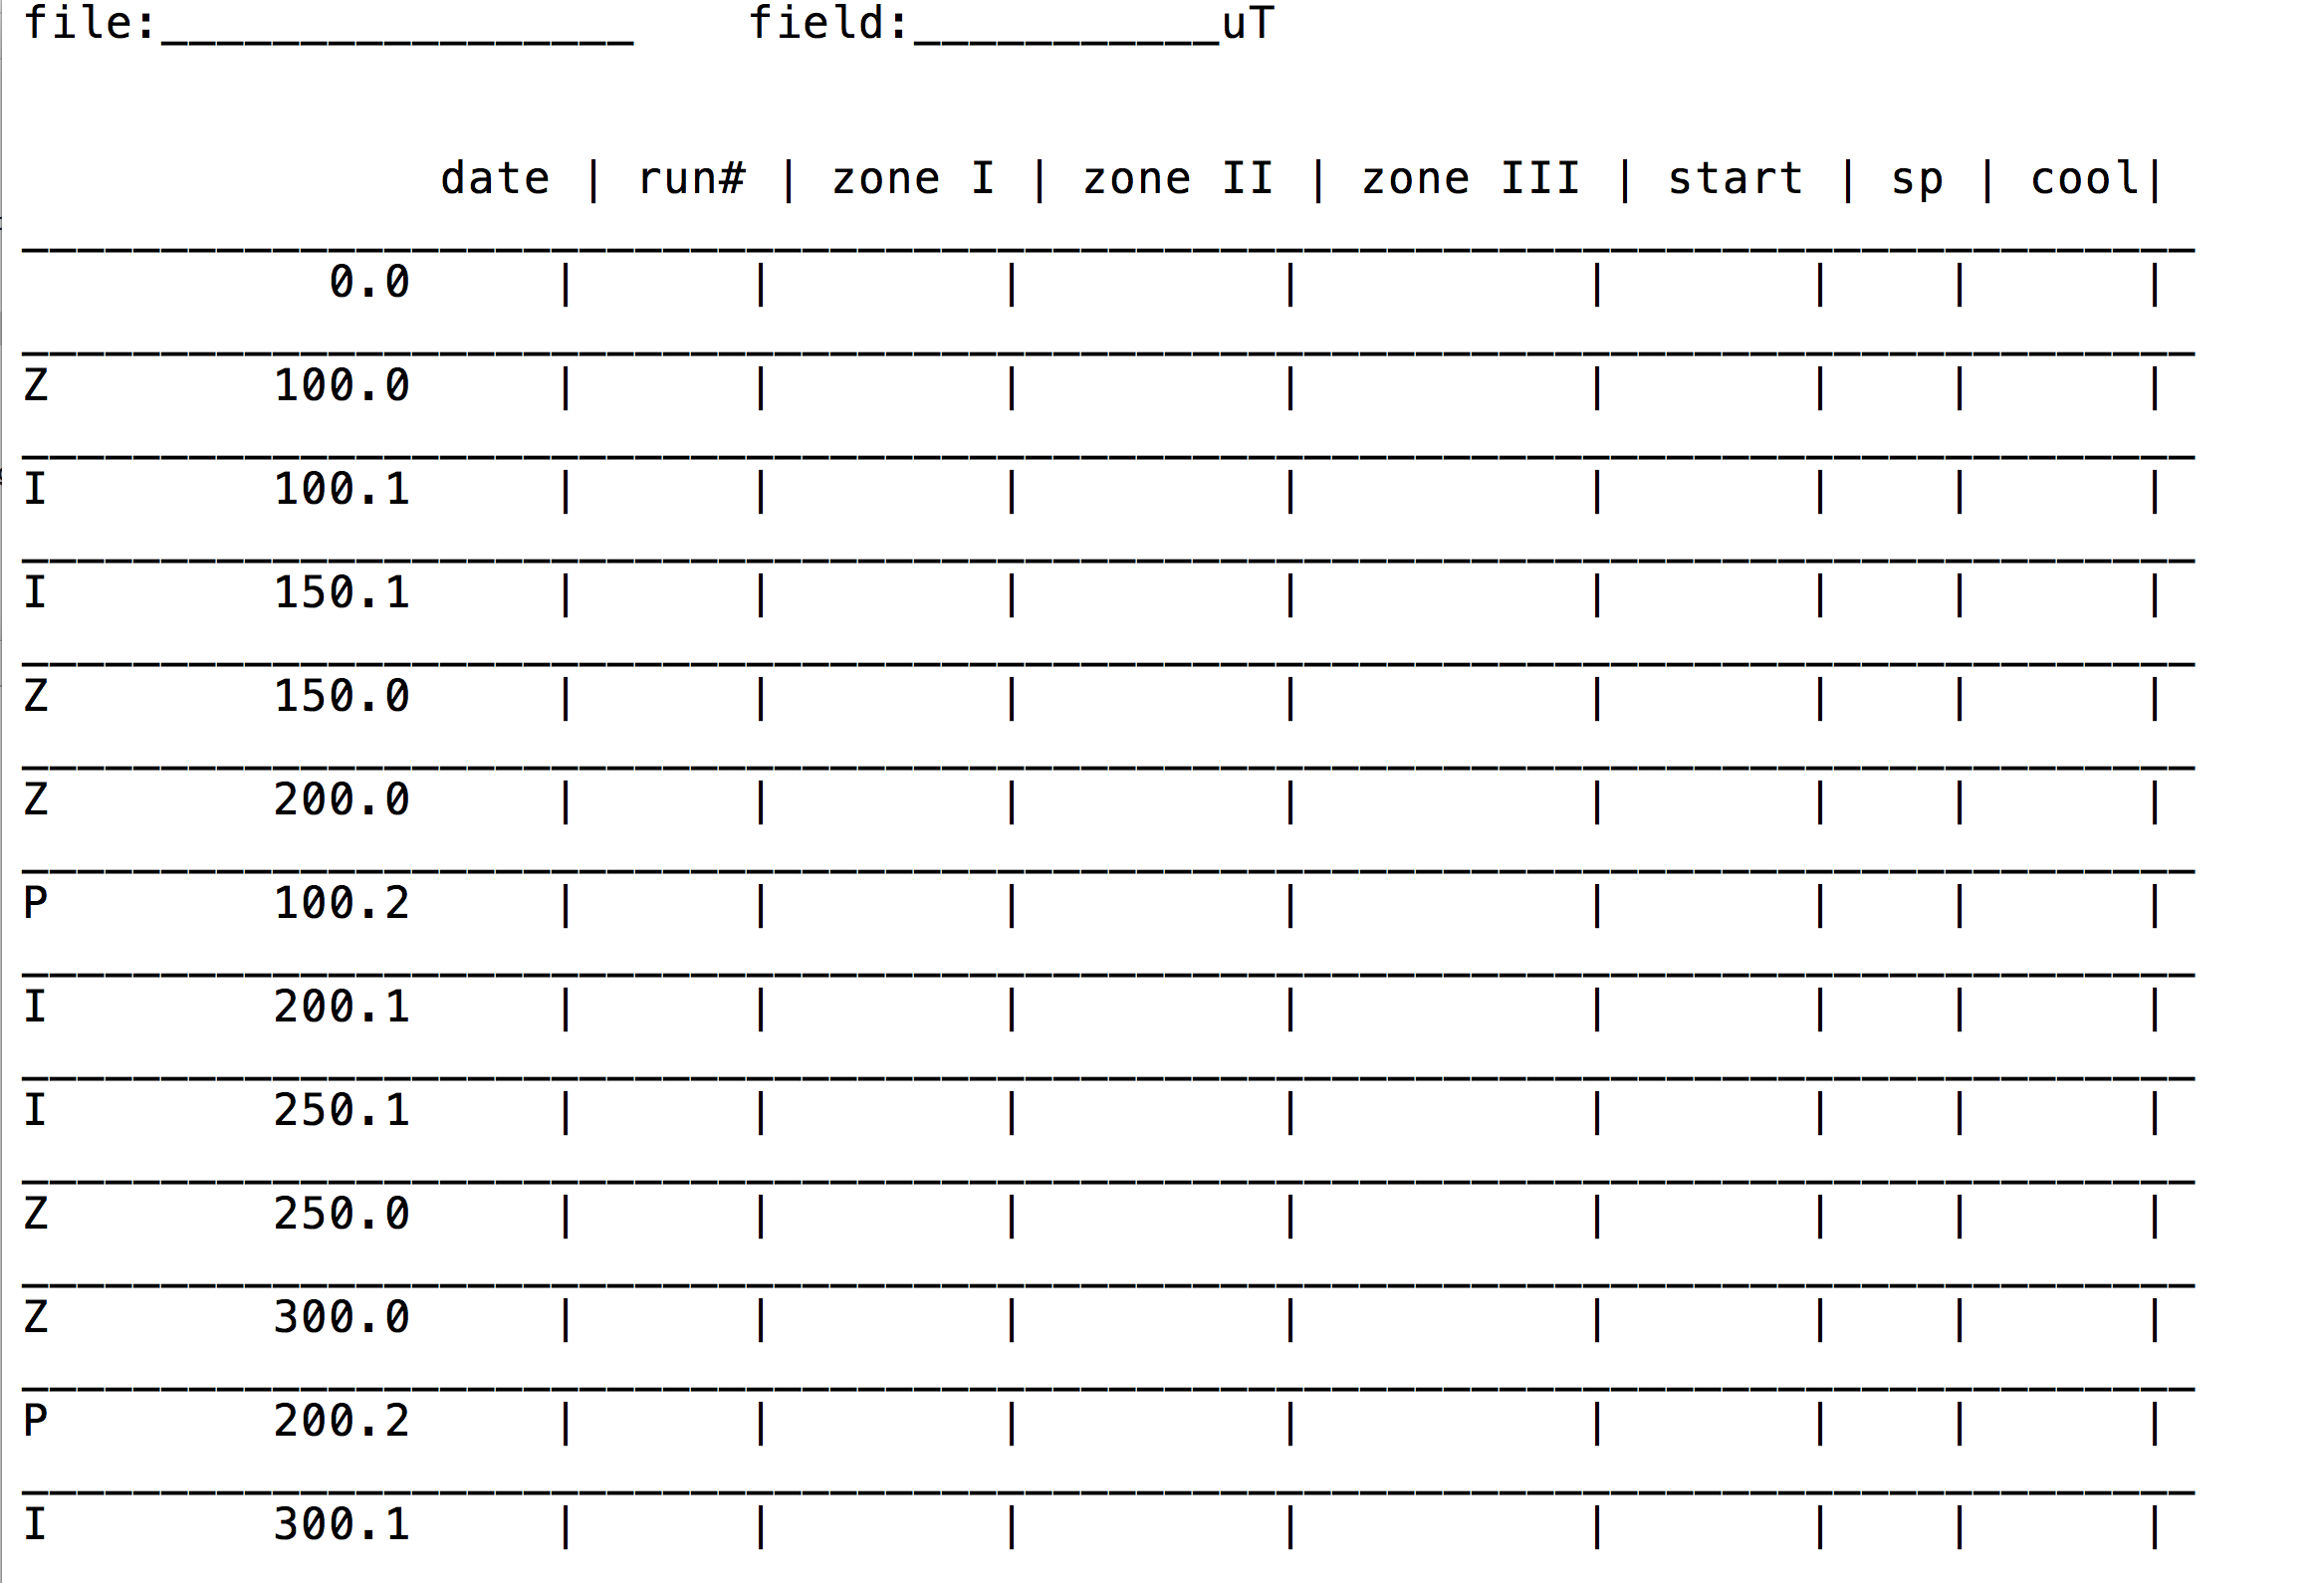

In [108]:
Image('data_files/Figures/chartmaker.png')

You can print it out and tape it to the oven in the lab to help keep track of this annoyingly complicated experiment.  :)  

To make this from within a notebook, call **pmag.chart_maker()**. 

In [109]:
help(pmag.chart_maker)

Help on function chart_maker in module pmagpy.pmag:

chart_maker(Int, Top, start=100, outfile='chart.txt')
    Makes a chart for performing IZZI experiments. Print out the file and
    tape it to the oven.  This chart will help keep track of the different
    steps.
    Z : performed in zero field - enter the temperature XXX.0 in the sio
        formatted measurement file created by the LabView program
    I : performed in the lab field written at the top of the form
    P : a pTRM step - performed at the temperature and in the lab field.
    
    Parameters
    __________
    Int : list of intervals [e.g., 50,10,5]
    Top : list of upper bounds for each interval [e.g., 500, 550, 600]
    start : first temperature step, default is 100
    outfile : name of output file, default is 'chart.txt'
    
    Output
    _________
    creates a file with:
         file:  write down the name of the measurement file
         field:  write down the lab field for the infield steps (in uT)
         

To perform 50 degree intervals from 100 to 500, followed by 10 degree intervals from 500 to 600 set up the Int and Top lists like this:

In [110]:
Int=[50,10]
Top=[500,600]

In [111]:
pmag.chart_maker(Int,Top)

output stored in: chart.txt


You can now print out chart.txt.  Happy IZZI-ing.  

## Clean up

In [16]:
import glob
import os
# remove some individual files

filenames = ['chart.txt',
            'data_files/azdip_magic/samples.txt', 'data_files/download_magic/criteria.txt', 
            'data_files/orientation_magic/samples.txt', 'data_files/orientation_magic/sites.txt',
            'data_files/download_magic/ages.txt', 'data_files/download_magic/contribution.txt', 
            'data_files/download_magic/measurements.txt', 'data_files/download_magic/samples.txt',
            'data_files/download_magic/specimens.txt', 'data_files/download_magic/locations.txt']


for fname in filenames:
    try:
        os.remove(fname)
    except FileNotFoundError:
        pass
  

# remove all MagIC-generated files from a given directory

def remove_magic_files(directory):
    magic_files = ['specimens.txt', 'samples.txt', 'sites.txt', 'locations.txt', 'measurements.txt', 
                   'contribution.txt', 'ages.txt']
    dir_files = os.listdir(directory)
    for dtype in magic_files:
        try:
            os.remove(dtype)
        except FileNotFoundError:
            pass
        for fname in dir_files:
            if fname.endswith(dtype):
                try:
                    os.remove(os.path.join(directory, fname))
                except FileNotFoundError:
                    pass
    for full_fname in glob.glob(os.path.join(directory, '*.magic')):
        os.remove(full_fname)
        
        
        
# not convert_2_magic/jr6_magic

for directory in ['.', 'data_files/convert_2_magic/2g_bin_magic/mn1', 'data_files/convert_2_magic/pmd_magic/PMD/',
                  'data_files', 'data_files/k15_s', 'data_files/convert_2_magic/agm_magic', 
                  'data_files/convert_2_magic/huji_magic', 'data_files/convert_2_magic/bgc_magic',
                  'data_files/convert_2_magic/kly4s_magic', 'data_files/convert_2_magic/mst_magic',
                  'data_files/convert_ages', 'data_files/convert_2_magic/cit_magic/MIT/7325B',
                  'data_files/convert_2_magic/cit_magic/USGS/bl9-1', 'data_files/convert_2_magic/tdt_magic',
                  'data_files/convert_2_magic/ldeo_magic', 'data_files/convert_2_magic/k15_magic',
                  'data_files/convert_2_magic/generic_magic']:
    remove_magic_files(directory)


lst = ['*.png', './data_files/convert_2_magic/jr6_magic/SML*.txt', './data_files/download_magic/Snake*',
      './data_files/convert_2_magic/jr6_magic/AP12_*.txt', 
      './data_files/convert_2_magic/jr6_magic/*_measurements.txt', './data_files/convert_2_magic/jr6_magic/*.magic',
      './data_files/3_0/McMurdo/*.tex', './data_files/3_0/McMurdo/*.xls', './data_files/3_0/Megiddo/*.tex',
      'data_files/3_0/Megiddo/*.xls', "./srm_arch*"]
for directory in lst:
    for fname in glob.glob(directory):
        os.remove(fname)  